In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

from lib.models import model
from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

# Device

In [2]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

# Manual Seeding

In [3]:
seed_generators()

# Data

In [4]:
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Server & Clients

In [6]:
num_clients = 8
num_classes = 10

## Data repartition among clients

In [7]:
proportions = generate_proportions(num_clients,num_classes)
proportions

[tensor([1.7277e-03, 1.4681e-03, 1.7119e-01, 6.7152e-08, 5.6816e-13, 3.8499e-02,
         1.0243e-05, 7.8711e-01]),
 tensor([1.0118e-01, 3.6152e-06, 1.2661e-02, 7.9172e-01, 5.1877e-21, 6.2118e-12,
         9.4433e-02, 3.0271e-15]),
 tensor([2.6149e-01, 2.5464e-01, 3.9212e-11, 8.3872e-11, 1.3594e-10, 3.5875e-01,
         1.1811e-01, 7.0036e-03]),
 tensor([9.6308e-04, 1.4171e-06, 6.7539e-05, 4.1170e-02, 8.3330e-04, 3.0664e-03,
         2.2048e-01, 7.3342e-01]),
 tensor([5.0231e-01, 2.2462e-11, 4.8773e-01, 1.6541e-03, 2.9940e-04, 9.7107e-06,
         6.0056e-03, 1.9903e-03]),
 tensor([6.4948e-06, 1.6067e-10, 9.1099e-09, 9.7064e-05, 1.0678e-03, 1.6058e-08,
         3.3956e-20, 9.9883e-01]),
 tensor([4.1385e-03, 8.2548e-01, 3.1079e-04, 2.0520e-11, 1.6359e-01, 5.3383e-07,
         3.7362e-05, 6.4420e-03]),
 tensor([8.4674e-01, 1.1771e-08, 8.1328e-03, 4.3720e-11, 7.8426e-02, 2.2480e-03,
         6.4372e-02, 7.9591e-05]),
 tensor([1.3971e-03, 7.3353e-18, 3.2855e-02, 1.9014e-01, 2.6827e-01, 5.9

# Cross Validation

In [8]:
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [9]:
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
        
        
    return torch.tensor(results).mean()

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.8845, Accuracy = 0.6442
client 2 : Loss = 0.3986, Accuracy = 0.8450
client 3 : Loss = 0.6325, Accuracy = 0.7908
client 4 : Loss = 0.5362, Accuracy = 0.7981
client 5 : Loss = 0.4616, Accuracy = 0.8325
client 6 : Loss = 0.3917, Accuracy = 0.8658
client 7 : Loss = 0.8297, Accuracy = 0.7155
client 8 : Loss = 0.6736, Accuracy = 0.6966

Server :
    - training loss = 3.7588
    - training accuracy = 0.0992
    - validation loss = 3.7215
    - validation accuracy = 0.1040
        
>>> Round 2 ...
client 1 : Loss = 0.8464, Accuracy = 0.6587
client 2 : Loss = 0.3744, Accuracy = 0.8385
client 3 : Loss = 0.5347, Accuracy = 0.8153
client 4 : Loss = 0.5773, Accuracy = 0.7725
client 5 : Loss = 0.4660, Accuracy = 0.8144
client 6 : Loss = 0.3751, Accuracy = 0.8906
cli

client 6 : Loss = 0.1216, Accuracy = 0.9553
client 7 : Loss = 0.1685, Accuracy = 0.9382
client 8 : Loss = 0.1006, Accuracy = 0.9624

Server :
    - training loss = 2.3300
    - training accuracy = 0.4890
    - validation loss = 2.5732
    - validation accuracy = 0.4708
        
>>> Round 17 ...
client 1 : Loss = 0.2458, Accuracy = 0.9109
client 2 : Loss = 0.0449, Accuracy = 0.9849
client 3 : Loss = 0.0687, Accuracy = 0.9747
client 4 : Loss = 0.1493, Accuracy = 0.9520
client 5 : Loss = 0.0605, Accuracy = 0.9804
client 6 : Loss = 0.1080, Accuracy = 0.9647
client 7 : Loss = 0.1376, Accuracy = 0.9490
client 8 : Loss = 0.0912, Accuracy = 0.9677

Server :
    - training loss = 2.3441
    - training accuracy = 0.4909
    - validation loss = 2.6104
    - validation accuracy = 0.4691
        
>>> Round 18 ...
client 1 : Loss = 0.0932, Accuracy = 0.9652
client 2 : Loss = 0.0441, Accuracy = 0.9851
client 3 : Loss = 0.0647, Accuracy = 0.9779
client 4 : Loss = 0.0893, Accuracy = 0.9721
client 5 : L

client 5 : Loss = 0.0391, Accuracy = 0.9853
client 6 : Loss = 0.0562, Accuracy = 0.9779
client 7 : Loss = 0.0596, Accuracy = 0.9821
client 8 : Loss = 0.0175, Accuracy = 0.9947

Server :
    - training loss = 2.2844
    - training accuracy = 0.5905
    - validation loss = 2.8986
    - validation accuracy = 0.5334
        
>>> Round 33 ...
client 1 : Loss = 0.1298, Accuracy = 0.9582
client 2 : Loss = 0.0186, Accuracy = 0.9961
client 3 : Loss = 0.0362, Accuracy = 0.9868
client 4 : Loss = 0.0147, Accuracy = 0.9946
client 5 : Loss = 0.0359, Accuracy = 0.9888
client 6 : Loss = 0.0560, Accuracy = 0.9748
client 7 : Loss = 0.0540, Accuracy = 0.9823
client 8 : Loss = 0.0299, Accuracy = 0.9904

Server :
    - training loss = 2.3392
    - training accuracy = 0.5861
    - validation loss = 2.9892
    - validation accuracy = 0.5272
        
>>> Round 34 ...
client 1 : Loss = 0.1928, Accuracy = 0.9411
client 2 : Loss = 0.0177, Accuracy = 0.9954
client 3 : Loss = 0.0386, Accuracy = 0.9861
client 4 : L

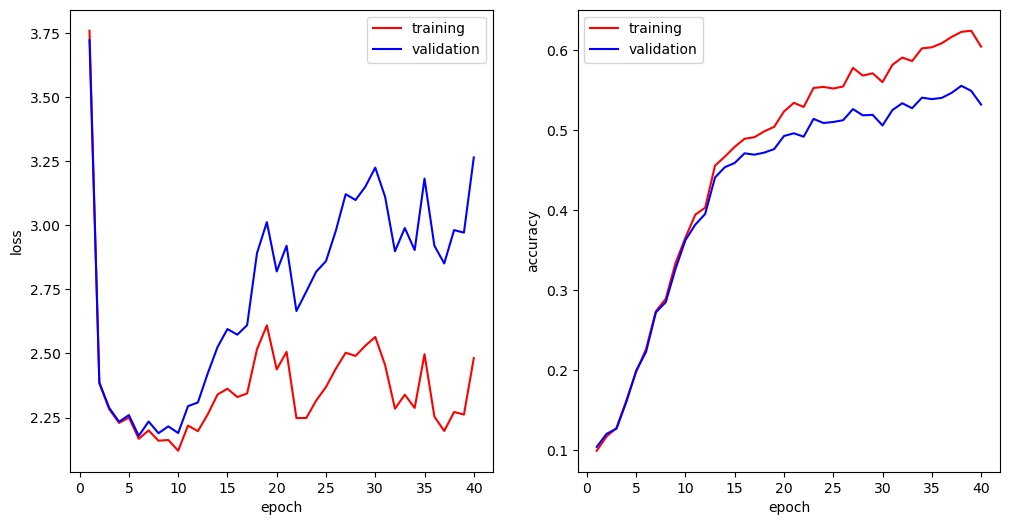

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.8281, Accuracy = 0.6669
client 2 : Loss = 0.3827, Accuracy = 0.8511
client 3 : Loss = 0.5776, Accuracy = 0.8146
client 4 : Loss = 0.5809, Accuracy = 0.7810
client 5 : Loss = 0.6132, Accuracy = 0.8114
client 6 : Loss = 0.4664, Accuracy = 0.8736
client 7 : Loss = 0.8115, Accuracy = 0.7142
client 8 : Loss = 0.6339, Accuracy = 0.7119

Server :
    - training loss = 3.2420
    - training accuracy = 0.1096
    - validation loss = 3.1733
    - validation accuracy = 0.1123
        
>>> Round 2 ...
client 1 : Loss = 0.7931, Accuracy = 0.6792
client 2 : Loss = 0.3290, Accuracy = 0.8572
client 3 : Loss = 0.5502, Accuracy = 0.8171
client 4 : Loss = 0.4831, Accuracy = 0.8123
client 5 : Loss = 0.5808, Accuracy = 0.7926
client 6 : Loss = 0.3402, Accuracy = 0.8776
cli

client 6 : Loss = 0.0739, Accuracy = 0.9710
client 7 : Loss = 0.1482, Accuracy = 0.9482
client 8 : Loss = 0.0822, Accuracy = 0.9704

Server :
    - training loss = 2.2120
    - training accuracy = 0.4803
    - validation loss = 2.3646
    - validation accuracy = 0.4605
        
>>> Round 17 ...
client 1 : Loss = 0.0759, Accuracy = 0.9746
client 2 : Loss = 0.0485, Accuracy = 0.9830
client 3 : Loss = 0.0824, Accuracy = 0.9744
client 4 : Loss = 0.0466, Accuracy = 0.9851
client 5 : Loss = 0.0966, Accuracy = 0.9617
client 6 : Loss = 0.0907, Accuracy = 0.9642
client 7 : Loss = 0.1546, Accuracy = 0.9461
client 8 : Loss = 0.0593, Accuracy = 0.9786

Server :
    - training loss = 2.0093
    - training accuracy = 0.4686
    - validation loss = 2.1838
    - validation accuracy = 0.4453
        
>>> Round 18 ...
client 1 : Loss = 0.0794, Accuracy = 0.9706
client 2 : Loss = 0.0532, Accuracy = 0.9824
client 3 : Loss = 0.0627, Accuracy = 0.9793
client 4 : Loss = 0.0440, Accuracy = 0.9851
client 5 : L

client 5 : Loss = 0.4351, Accuracy = 0.9144
client 6 : Loss = 0.0429, Accuracy = 0.9864
client 7 : Loss = 0.0535, Accuracy = 0.9810
client 8 : Loss = 0.0123, Accuracy = 0.9957

Server :
    - training loss = 2.2423
    - training accuracy = 0.5239
    - validation loss = 2.5389
    - validation accuracy = 0.4687
        
>>> Round 33 ...
client 1 : Loss = 0.0241, Accuracy = 0.9926
client 2 : Loss = 0.0544, Accuracy = 0.9837
client 3 : Loss = 0.0409, Accuracy = 0.9874
client 4 : Loss = 0.0255, Accuracy = 0.9920
client 5 : Loss = 0.1781, Accuracy = 0.9643
client 6 : Loss = 0.0505, Accuracy = 0.9830
client 7 : Loss = 0.0636, Accuracy = 0.9792
client 8 : Loss = 0.0153, Accuracy = 0.9946

Server :
    - training loss = 2.1090
    - training accuracy = 0.5606
    - validation loss = 2.4600
    - validation accuracy = 0.5089
        
>>> Round 34 ...
client 1 : Loss = 0.0265, Accuracy = 0.9913
client 2 : Loss = 0.0268, Accuracy = 0.9935
client 3 : Loss = 0.0395, Accuracy = 0.9857
client 4 : L

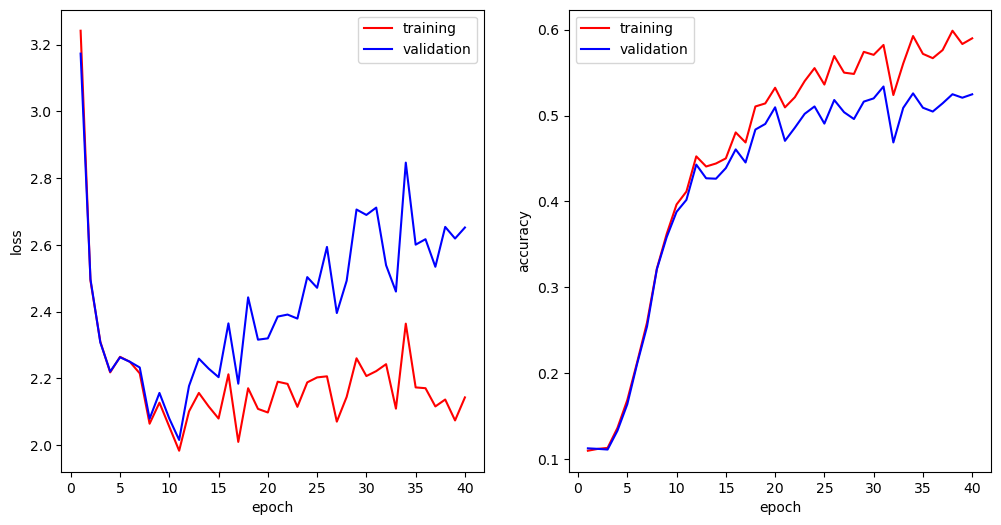

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.8086, Accuracy = 0.6742
client 2 : Loss = 0.3958, Accuracy = 0.8522
client 3 : Loss = 0.5948, Accuracy = 0.8027
client 4 : Loss = 0.6903, Accuracy = 0.7316
client 5 : Loss = 0.6833, Accuracy = 0.7944
client 6 : Loss = 0.3625, Accuracy = 0.8870
client 7 : Loss = 0.7574, Accuracy = 0.7161
client 8 : Loss = 0.6349, Accuracy = 0.7159

Server :
    - training loss = 3.5526
    - training accuracy = 0.1038
    - validation loss = 3.5374
    - validation accuracy = 0.1005
        
>>> Round 2 ...
client 1 : Loss = 0.7550, Accuracy = 0.6920
client 2 : Loss = 0.3461, Accuracy = 0.8535
client 3 : Loss = 0.5201, Accuracy = 0.8184
client 4 : Loss = 0.5165, Accuracy = 0.8038
client 5 : Loss = 0.4553, Accuracy = 0.8400
client 6 : Loss = 0.3683, Accuracy = 0.8840
cli

client 6 : Loss = 0.1024, Accuracy = 0.9619
client 7 : Loss = 0.1451, Accuracy = 0.9464
client 8 : Loss = 0.0885, Accuracy = 0.9676

Server :
    - training loss = 2.2518
    - training accuracy = 0.5003
    - validation loss = 2.3819
    - validation accuracy = 0.4733
        
>>> Round 17 ...
client 1 : Loss = 0.0862, Accuracy = 0.9699
client 2 : Loss = 0.0732, Accuracy = 0.9762
client 3 : Loss = 0.1021, Accuracy = 0.9679
client 4 : Loss = 0.0875, Accuracy = 0.9701
client 5 : Loss = 0.4222, Accuracy = 0.9283
client 6 : Loss = 0.0775, Accuracy = 0.9708
client 7 : Loss = 0.1270, Accuracy = 0.9532
client 8 : Loss = 0.0762, Accuracy = 0.9736

Server :
    - training loss = 2.2825
    - training accuracy = 0.4959
    - validation loss = 2.4388
    - validation accuracy = 0.4712
        
>>> Round 18 ...
client 1 : Loss = 0.0774, Accuracy = 0.9736
client 2 : Loss = 0.0603, Accuracy = 0.9744
client 3 : Loss = 0.0980, Accuracy = 0.9640
client 4 : Loss = 0.0876, Accuracy = 0.9705
client 5 : L

client 5 : Loss = 0.1079, Accuracy = 0.9688
client 6 : Loss = 0.0358, Accuracy = 0.9884
client 7 : Loss = 0.0544, Accuracy = 0.9812
client 8 : Loss = 0.0172, Accuracy = 0.9943

Server :
    - training loss = 2.5512
    - training accuracy = 0.5471
    - validation loss = 2.9588
    - validation accuracy = 0.4984
        
>>> Round 33 ...
client 1 : Loss = 0.0305, Accuracy = 0.9896
client 2 : Loss = 0.0264, Accuracy = 0.9895
client 3 : Loss = 0.0428, Accuracy = 0.9870
client 4 : Loss = 0.0302, Accuracy = 0.9892
client 5 : Loss = 0.0431, Accuracy = 0.9899
client 6 : Loss = 0.0403, Accuracy = 0.9858
client 7 : Loss = 0.0522, Accuracy = 0.9822
client 8 : Loss = 0.0163, Accuracy = 0.9946

Server :
    - training loss = 2.3925
    - training accuracy = 0.5509
    - validation loss = 2.7993
    - validation accuracy = 0.5020
        
>>> Round 34 ...
client 1 : Loss = 0.0306, Accuracy = 0.9894
client 2 : Loss = 0.0238, Accuracy = 0.9917
client 3 : Loss = 0.0491, Accuracy = 0.9837
client 4 : L

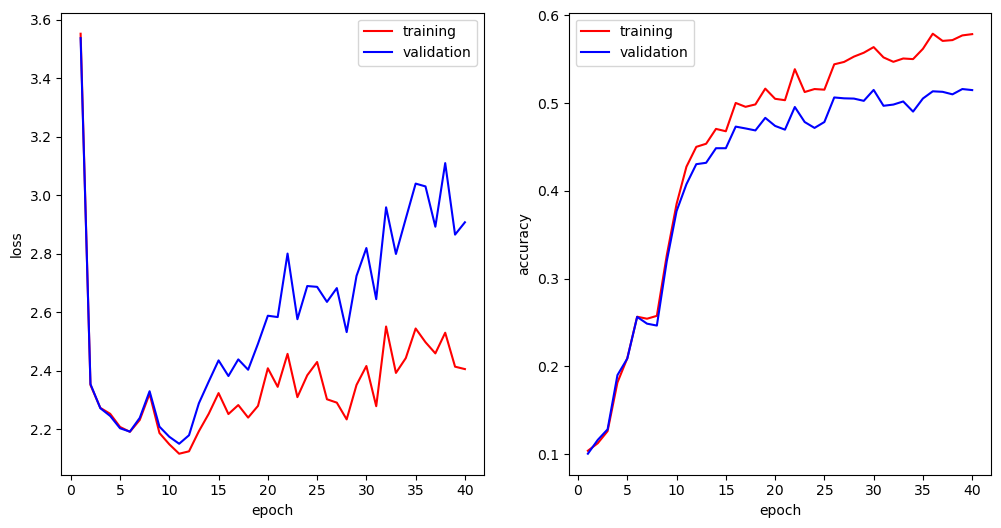

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.7640, Accuracy = 0.6906
client 2 : Loss = 0.4504, Accuracy = 0.8266
client 3 : Loss = 0.6945, Accuracy = 0.7704
client 4 : Loss = 0.5046, Accuracy = 0.8040
client 5 : Loss = 0.7141, Accuracy = 0.7621
client 6 : Loss = 0.3654, Accuracy = 0.8808
client 7 : Loss = 0.8124, Accuracy = 0.7004
client 8 : Loss = 0.6242, Accuracy = 0.7165

Server :
    - training loss = 3.7077
    - training accuracy = 0.1021
    - validation loss = 3.7537
    - validation accuracy = 0.0963
        
>>> Round 2 ...
client 1 : Loss = 0.7976, Accuracy = 0.6721
client 2 : Loss = 0.3625, Accuracy = 0.8424
client 3 : Loss = 0.5830, Accuracy = 0.7955
client 4 : Loss = 0.5325, Accuracy = 0.7959
client 5 : Loss = 0.6065, Accuracy = 0.7857
client 6 : Loss = 0.3343, Accuracy = 0.8914
cli

client 6 : Loss = 0.0863, Accuracy = 0.9657
client 7 : Loss = 0.1100, Accuracy = 0.9597
client 8 : Loss = 0.0612, Accuracy = 0.9786

Server :
    - training loss = 2.0099
    - training accuracy = 0.4806
    - validation loss = 2.1347
    - validation accuracy = 0.4608
        
>>> Round 17 ...
client 1 : Loss = 0.0711, Accuracy = 0.9744
client 2 : Loss = 0.0334, Accuracy = 0.9880
client 3 : Loss = 0.1163, Accuracy = 0.9565
client 4 : Loss = 0.0591, Accuracy = 0.9787
client 5 : Loss = 0.0816, Accuracy = 0.9770
client 6 : Loss = 0.0648, Accuracy = 0.9790
client 7 : Loss = 0.1169, Accuracy = 0.9587
client 8 : Loss = 0.0519, Accuracy = 0.9824

Server :
    - training loss = 1.9078
    - training accuracy = 0.4943
    - validation loss = 2.0638
    - validation accuracy = 0.4646
        
>>> Round 18 ...
client 1 : Loss = 0.0679, Accuracy = 0.9752
client 2 : Loss = 0.0359, Accuracy = 0.9890
client 3 : Loss = 0.0924, Accuracy = 0.9674
client 4 : Loss = 0.0368, Accuracy = 0.9867
client 5 : L

client 5 : Loss = 0.1243, Accuracy = 0.9637
client 6 : Loss = 0.0330, Accuracy = 0.9878
client 7 : Loss = 0.0487, Accuracy = 0.9844
client 8 : Loss = 0.0187, Accuracy = 0.9936

Server :
    - training loss = 1.5766
    - training accuracy = 0.5936
    - validation loss = 1.9482
    - validation accuracy = 0.5249
        
>>> Round 33 ...
client 1 : Loss = 0.0250, Accuracy = 0.9931
client 2 : Loss = 0.0183, Accuracy = 0.9954
client 3 : Loss = 0.0789, Accuracy = 0.9711
client 4 : Loss = 0.0192, Accuracy = 0.9939
client 5 : Loss = 0.0619, Accuracy = 0.9803
client 6 : Loss = 0.0377, Accuracy = 0.9866
client 7 : Loss = 0.0415, Accuracy = 0.9863
client 8 : Loss = 0.0253, Accuracy = 0.9925

Server :
    - training loss = 1.6741
    - training accuracy = 0.5996
    - validation loss = 2.0837
    - validation accuracy = 0.5243
        
>>> Round 34 ...
client 1 : Loss = 0.0280, Accuracy = 0.9911
client 2 : Loss = 0.0195, Accuracy = 0.9941
client 3 : Loss = 0.0591, Accuracy = 0.9823
client 4 : L

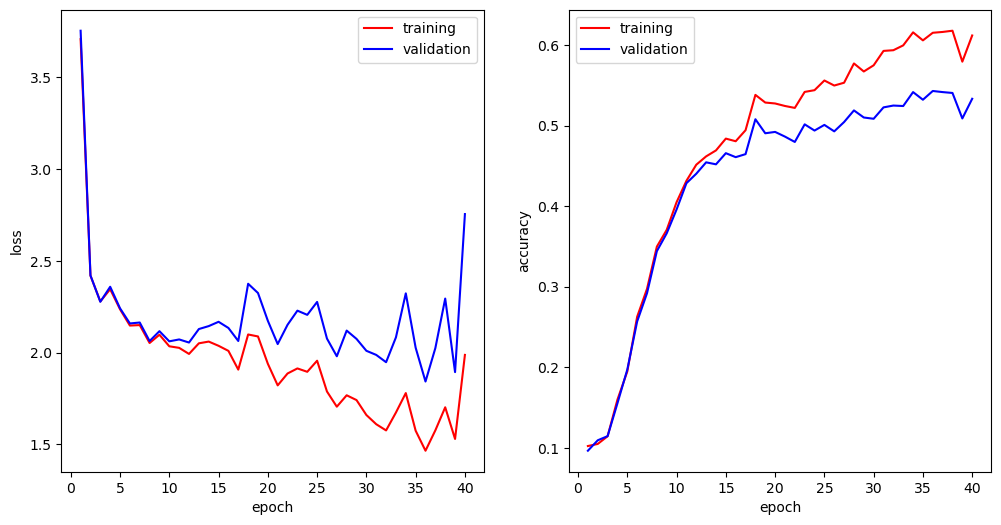

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.7955, Accuracy = 0.6779
client 2 : Loss = 0.4043, Accuracy = 0.8445
client 3 : Loss = 0.5732, Accuracy = 0.8009
client 4 : Loss = 0.5263, Accuracy = 0.8035
client 5 : Loss = 0.5434, Accuracy = 0.8101
client 6 : Loss = 0.3863, Accuracy = 0.8782
client 7 : Loss = 0.7586, Accuracy = 0.7273
client 8 : Loss = 0.6539, Accuracy = 0.7048

Server :
    - training loss = 3.3341
    - training accuracy = 0.1008
    - validation loss = 3.3056
    - validation accuracy = 0.0957
        
>>> Round 2 ...
client 1 : Loss = 0.7279, Accuracy = 0.7040
client 2 : Loss = 0.3779, Accuracy = 0.8427
client 3 : Loss = 0.5465, Accuracy = 0.8117
client 4 : Loss = 0.4558, Accuracy = 0.8260
client 5 : Loss = 0.4341, Accuracy = 0.8390
client 6 : Loss = 0.3491, Accuracy = 0.8845
cli

client 6 : Loss = 0.0690, Accuracy = 0.9719
client 7 : Loss = 0.1654, Accuracy = 0.9387
client 8 : Loss = 0.0813, Accuracy = 0.9714

Server :
    - training loss = 1.7672
    - training accuracy = 0.5095
    - validation loss = 1.8664
    - validation accuracy = 0.4808
        
>>> Round 17 ...
client 1 : Loss = 0.0977, Accuracy = 0.9647
client 2 : Loss = 0.0505, Accuracy = 0.9824
client 3 : Loss = 0.0752, Accuracy = 0.9750
client 4 : Loss = 0.0352, Accuracy = 0.9884
client 5 : Loss = 0.0517, Accuracy = 0.9809
client 6 : Loss = 0.0699, Accuracy = 0.9773
client 7 : Loss = 0.1477, Accuracy = 0.9510
client 8 : Loss = 0.0692, Accuracy = 0.9718

Server :
    - training loss = 1.6848
    - training accuracy = 0.5219
    - validation loss = 1.8090
    - validation accuracy = 0.5006
        
>>> Round 18 ...
client 1 : Loss = 0.0771, Accuracy = 0.9726
client 2 : Loss = 0.0465, Accuracy = 0.9816
client 3 : Loss = 0.0736, Accuracy = 0.9722
client 4 : Loss = 0.0360, Accuracy = 0.9875
client 5 : L

client 5 : Loss = 0.0331, Accuracy = 0.9897
client 6 : Loss = 0.0400, Accuracy = 0.9866
client 7 : Loss = 0.0493, Accuracy = 0.9819
client 8 : Loss = 0.0185, Accuracy = 0.9947

Server :
    - training loss = 1.7922
    - training accuracy = 0.5782
    - validation loss = 2.0993
    - validation accuracy = 0.5293
        
>>> Round 33 ...
client 1 : Loss = 0.0298, Accuracy = 0.9919
client 2 : Loss = 0.0235, Accuracy = 0.9934
client 3 : Loss = 0.0449, Accuracy = 0.9834
client 4 : Loss = 0.0198, Accuracy = 0.9939
client 5 : Loss = 0.0305, Accuracy = 0.9917
client 6 : Loss = 0.0439, Accuracy = 0.9848
client 7 : Loss = 0.0640, Accuracy = 0.9796
client 8 : Loss = 0.0153, Accuracy = 0.9950

Server :
    - training loss = 1.8301
    - training accuracy = 0.6007
    - validation loss = 2.1835
    - validation accuracy = 0.5444
        
>>> Round 34 ...
client 1 : Loss = 0.0258, Accuracy = 0.9912
client 2 : Loss = 0.0195, Accuracy = 0.9944
client 3 : Loss = 0.0501, Accuracy = 0.9811
client 4 : L

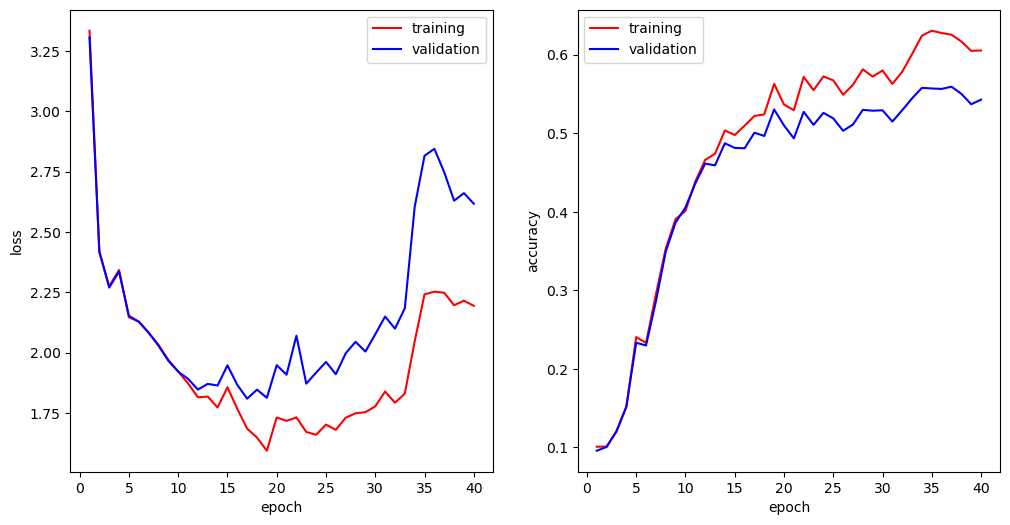

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.6009, Accuracy = 0.7588
client 2 : Loss = 0.2220, Accuracy = 0.9165
client 3 : Loss = 0.4295, Accuracy = 0.8397
client 4 : Loss = 0.3072, Accuracy = 0.8837
client 5 : Loss = 0.2567, Accuracy = 0.9145
client 6 : Loss = 0.3007, Accuracy = 0.8924
client 7 : Loss = 0.4825, Accuracy = 0.8262
client 8 : Loss = 0.4849, Accuracy = 0.7916

Server :
    - training loss = 2.4703
    - training accuracy = 0.2538
    - validation loss = 2.5070
    - validation accuracy = 0.2514
        
>>> Round 2 ...
client 1 : Loss = 0.4794, Accuracy = 0.8179
client 2 : Loss = 0.1724, Accuracy = 0.9296
client 3 : Loss = 0.3796, Accuracy = 0.8634
client 4 : Loss = 0.2470, Accuracy = 0.9082
client 5 : Loss = 0.1972, Accuracy = 0.9292
client 6 : Loss = 0.2135, Accuracy = 0.9277
cli

client 6 : Loss = 0.0107, Accuracy = 0.9994
client 7 : Loss = 0.0242, Accuracy = 0.9948
client 8 : Loss = 0.0068, Accuracy = 0.9990

Server :
    - training loss = 1.3740
    - training accuracy = 0.6821
    - validation loss = 1.8813
    - validation accuracy = 0.5913
        
>>> Round 17 ...
client 1 : Loss = 0.1034, Accuracy = 0.9688
client 2 : Loss = 0.0164, Accuracy = 0.9956
client 3 : Loss = 0.0152, Accuracy = 0.9969
client 4 : Loss = 0.0180, Accuracy = 0.9941
client 5 : Loss = 0.0093, Accuracy = 0.9980
client 6 : Loss = 0.0095, Accuracy = 0.9994
client 7 : Loss = 0.0203, Accuracy = 0.9975
client 8 : Loss = 0.0059, Accuracy = 0.9993

Server :
    - training loss = 1.4351
    - training accuracy = 0.6886
    - validation loss = 1.9612
    - validation accuracy = 0.5911
        
>>> Round 18 ...
client 1 : Loss = 0.0966, Accuracy = 0.9781
client 2 : Loss = 0.0217, Accuracy = 0.9938
client 3 : Loss = 0.0130, Accuracy = 0.9976
client 4 : Loss = 0.0379, Accuracy = 0.9915
client 5 : L

client 5 : Loss = 0.0028, Accuracy = 1.0000
client 6 : Loss = 0.0060, Accuracy = 0.9988
client 7 : Loss = 0.0093, Accuracy = 0.9985
client 8 : Loss = 0.0034, Accuracy = 0.9993

Server :
    - training loss = 0.9477
    - training accuracy = 0.7654
    - validation loss = 1.7866
    - validation accuracy = 0.6206
        
>>> Round 33 ...
client 1 : Loss = 0.0321, Accuracy = 0.9869
client 2 : Loss = 0.0090, Accuracy = 0.9968
client 3 : Loss = 0.0100, Accuracy = 0.9973
client 4 : Loss = 0.0040, Accuracy = 0.9996
client 5 : Loss = 0.0048, Accuracy = 0.9980
client 6 : Loss = 0.0044, Accuracy = 1.0000
client 7 : Loss = 0.0109, Accuracy = 0.9972
client 8 : Loss = 0.0024, Accuracy = 0.9997

Server :
    - training loss = 1.0084
    - training accuracy = 0.7593
    - validation loss = 1.8477
    - validation accuracy = 0.6105
        
>>> Round 34 ...
client 1 : Loss = 0.0806, Accuracy = 0.9847
client 2 : Loss = 0.0073, Accuracy = 0.9979
client 3 : Loss = 0.0061, Accuracy = 0.9986
client 4 : L

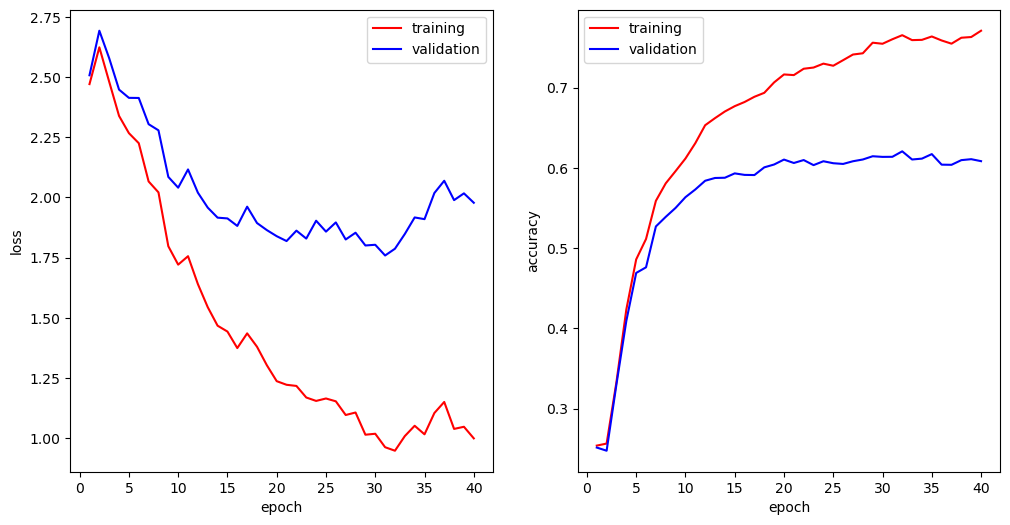

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.4620, Accuracy = 0.8225
client 2 : Loss = 0.1980, Accuracy = 0.9226
client 3 : Loss = 0.4444, Accuracy = 0.8423
client 4 : Loss = 0.3009, Accuracy = 0.8879
client 5 : Loss = 0.2904, Accuracy = 0.8987
client 6 : Loss = 0.2733, Accuracy = 0.9108
client 7 : Loss = 0.5123, Accuracy = 0.8096
client 8 : Loss = 0.4578, Accuracy = 0.8013

Server :
    - training loss = 2.4183
    - training accuracy = 0.2625
    - validation loss = 2.4268
    - validation accuracy = 0.2533
        
>>> Round 2 ...
client 1 : Loss = 0.3651, Accuracy = 0.8613
client 2 : Loss = 0.2075, Accuracy = 0.9237
client 3 : Loss = 0.3713, Accuracy = 0.8686
client 4 : Loss = 0.2489, Accuracy = 0.9084
client 5 : Loss = 0.2349, Accuracy = 0.9093
client 6 : Loss = 0.1722, Accuracy = 0.9434
cli

client 6 : Loss = 0.0130, Accuracy = 0.9994
client 7 : Loss = 0.0184, Accuracy = 0.9974
client 8 : Loss = 0.0061, Accuracy = 0.9992

Server :
    - training loss = 1.9408
    - training accuracy = 0.6759
    - validation loss = 2.4056
    - validation accuracy = 0.5969
        
>>> Round 17 ...
client 1 : Loss = 0.0126, Accuracy = 0.9991
client 2 : Loss = 0.0155, Accuracy = 0.9960
client 3 : Loss = 0.0171, Accuracy = 0.9940
client 4 : Loss = 0.0094, Accuracy = 0.9993
client 5 : Loss = 0.0153, Accuracy = 0.9968
client 6 : Loss = 0.0121, Accuracy = 0.9982
client 7 : Loss = 0.0194, Accuracy = 0.9973
client 8 : Loss = 0.0088, Accuracy = 0.9982

Server :
    - training loss = 1.8317
    - training accuracy = 0.6934
    - validation loss = 2.3184
    - validation accuracy = 0.5991
        
>>> Round 18 ...
client 1 : Loss = 0.0120, Accuracy = 0.9986
client 2 : Loss = 0.0229, Accuracy = 0.9926
client 3 : Loss = 0.0301, Accuracy = 0.9918
client 4 : Loss = 0.0135, Accuracy = 0.9968
client 5 : L

client 5 : Loss = 0.0606, Accuracy = 0.9885
client 6 : Loss = 0.0062, Accuracy = 0.9994
client 7 : Loss = 0.0125, Accuracy = 0.9976
client 8 : Loss = 0.0018, Accuracy = 0.9999

Server :
    - training loss = 1.2955
    - training accuracy = 0.7443
    - validation loss = 2.1786
    - validation accuracy = 0.6072
        
>>> Round 33 ...
client 1 : Loss = 0.0056, Accuracy = 0.9991
client 2 : Loss = 0.0094, Accuracy = 0.9973
client 3 : Loss = 0.0082, Accuracy = 0.9977
client 4 : Loss = 0.0055, Accuracy = 0.9989
client 5 : Loss = 0.0431, Accuracy = 0.9799
client 6 : Loss = 0.0088, Accuracy = 0.9982
client 7 : Loss = 0.0070, Accuracy = 0.9993
client 8 : Loss = 0.0020, Accuracy = 0.9998

Server :
    - training loss = 1.2822
    - training accuracy = 0.7444
    - validation loss = 2.1440
    - validation accuracy = 0.6096
        
>>> Round 34 ...
client 1 : Loss = 0.0048, Accuracy = 0.9993
client 2 : Loss = 0.0100, Accuracy = 0.9971
client 3 : Loss = 0.0069, Accuracy = 0.9993
client 4 : L

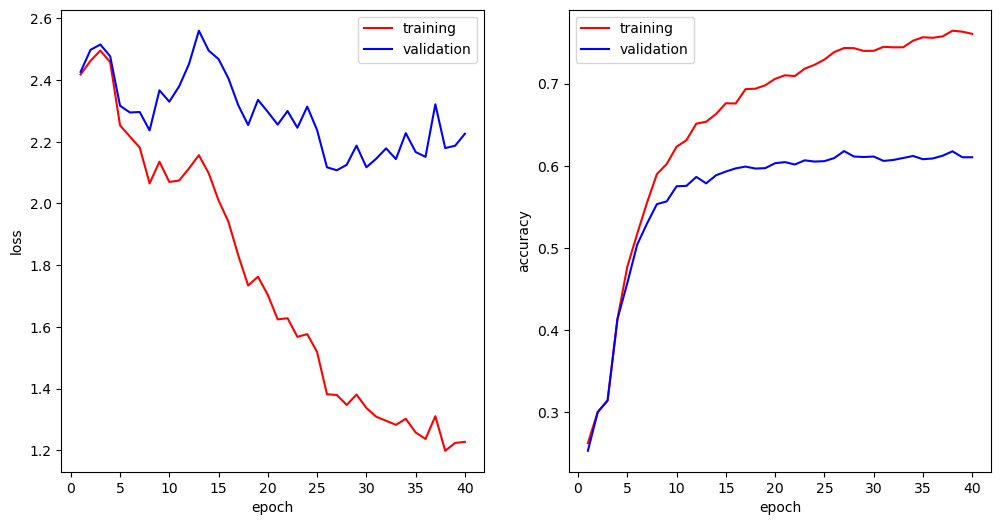

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.4087, Accuracy = 0.8432
client 2 : Loss = 0.2388, Accuracy = 0.9051
client 3 : Loss = 0.4070, Accuracy = 0.8606
client 4 : Loss = 0.2946, Accuracy = 0.8953
client 5 : Loss = 0.3082, Accuracy = 0.8980
client 6 : Loss = 0.2047, Accuracy = 0.9327
client 7 : Loss = 0.4568, Accuracy = 0.8366
client 8 : Loss = 0.4556, Accuracy = 0.8064

Server :
    - training loss = 2.4074
    - training accuracy = 0.2517
    - validation loss = 2.4199
    - validation accuracy = 0.2508
        
>>> Round 2 ...
client 1 : Loss = 0.3524, Accuracy = 0.8699
client 2 : Loss = 0.1540, Accuracy = 0.9400
client 3 : Loss = 0.3241, Accuracy = 0.8772
client 4 : Loss = 0.2031, Accuracy = 0.9277
client 5 : Loss = 0.2786, Accuracy = 0.9060
client 6 : Loss = 0.2115, Accuracy = 0.9281
cli

client 6 : Loss = 0.0139, Accuracy = 0.9974
client 7 : Loss = 0.0159, Accuracy = 0.9988
client 8 : Loss = 0.0071, Accuracy = 0.9994

Server :
    - training loss = 1.3478
    - training accuracy = 0.6938
    - validation loss = 1.8548
    - validation accuracy = 0.5898
        
>>> Round 17 ...
client 1 : Loss = 0.0115, Accuracy = 0.9975
client 2 : Loss = 0.0109, Accuracy = 0.9977
client 3 : Loss = 0.0129, Accuracy = 0.9983
client 4 : Loss = 0.0094, Accuracy = 0.9980
client 5 : Loss = 0.0952, Accuracy = 0.9706
client 6 : Loss = 0.0119, Accuracy = 0.9988
client 7 : Loss = 0.0157, Accuracy = 0.9990
client 8 : Loss = 0.0059, Accuracy = 0.9994

Server :
    - training loss = 1.3566
    - training accuracy = 0.7054
    - validation loss = 1.8581
    - validation accuracy = 0.6003
        
>>> Round 18 ...
client 1 : Loss = 0.0090, Accuracy = 0.9991
client 2 : Loss = 0.0117, Accuracy = 0.9977
client 3 : Loss = 0.0133, Accuracy = 0.9983
client 4 : Loss = 0.0125, Accuracy = 0.9973
client 5 : L

client 5 : Loss = 0.0268, Accuracy = 0.9936
client 6 : Loss = 0.0050, Accuracy = 0.9986
client 7 : Loss = 0.0074, Accuracy = 0.9988
client 8 : Loss = 0.0027, Accuracy = 0.9998

Server :
    - training loss = 1.0792
    - training accuracy = 0.7592
    - validation loss = 1.9213
    - validation accuracy = 0.6074
        
>>> Round 33 ...
client 1 : Loss = 0.0048, Accuracy = 0.9990
client 2 : Loss = 0.0069, Accuracy = 0.9986
client 3 : Loss = 0.0090, Accuracy = 0.9972
client 4 : Loss = 0.0262, Accuracy = 0.9935
client 5 : Loss = 0.0060, Accuracy = 0.9991
client 6 : Loss = 0.0061, Accuracy = 0.9982
client 7 : Loss = 0.0056, Accuracy = 0.9998
client 8 : Loss = 0.0028, Accuracy = 0.9996

Server :
    - training loss = 1.1158
    - training accuracy = 0.7596
    - validation loss = 1.9699
    - validation accuracy = 0.6050
        
>>> Round 34 ...
client 1 : Loss = 0.0035, Accuracy = 0.9997
client 2 : Loss = 0.0064, Accuracy = 0.9989
client 3 : Loss = 0.0057, Accuracy = 0.9997
client 4 : L

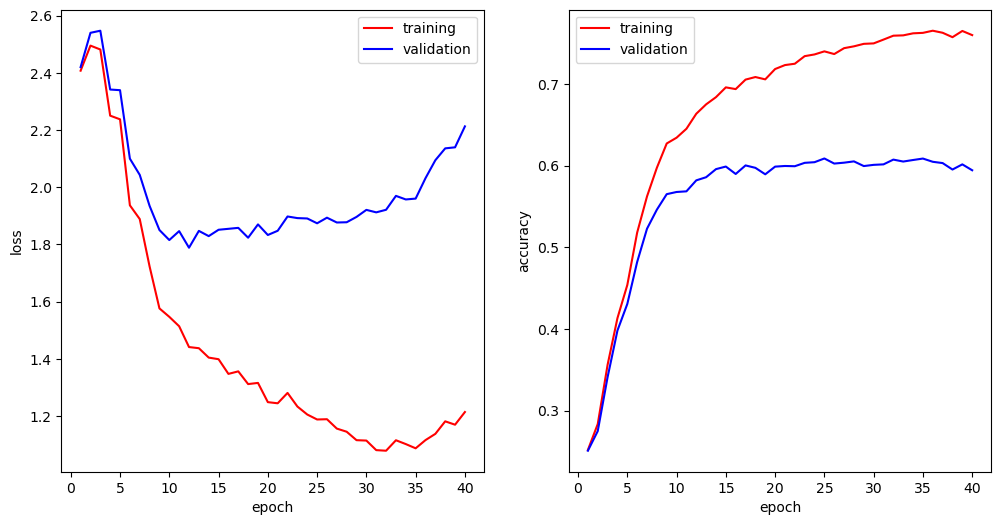

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.4882, Accuracy = 0.8173
client 2 : Loss = 0.1711, Accuracy = 0.9320
client 3 : Loss = 0.4991, Accuracy = 0.8346
client 4 : Loss = 0.2675, Accuracy = 0.9011
client 5 : Loss = 0.3224, Accuracy = 0.8753
client 6 : Loss = 0.2006, Accuracy = 0.9285
client 7 : Loss = 0.4845, Accuracy = 0.8223
client 8 : Loss = 0.4487, Accuracy = 0.8090

Server :
    - training loss = 2.3498
    - training accuracy = 0.2721
    - validation loss = 2.3602
    - validation accuracy = 0.2773
        
>>> Round 2 ...
client 1 : Loss = 0.3559, Accuracy = 0.8632
client 2 : Loss = 0.1517, Accuracy = 0.9427
client 3 : Loss = 0.4742, Accuracy = 0.8288
client 4 : Loss = 0.1963, Accuracy = 0.9292
client 5 : Loss = 0.2669, Accuracy = 0.9105
client 6 : Loss = 0.1366, Accuracy = 0.9462
cli

client 6 : Loss = 0.0133, Accuracy = 0.9988
client 7 : Loss = 0.0170, Accuracy = 0.9978
client 8 : Loss = 0.0055, Accuracy = 0.9995

Server :
    - training loss = 1.6236
    - training accuracy = 0.6837
    - validation loss = 2.1096
    - validation accuracy = 0.5819
        
>>> Round 17 ...
client 1 : Loss = 0.0103, Accuracy = 0.9991
client 2 : Loss = 0.0141, Accuracy = 0.9972
client 3 : Loss = 0.0223, Accuracy = 0.9969
client 4 : Loss = 0.0109, Accuracy = 0.9983
client 5 : Loss = 0.0160, Accuracy = 0.9972
client 6 : Loss = 0.0126, Accuracy = 0.9970
client 7 : Loss = 0.0132, Accuracy = 0.9988
client 8 : Loss = 0.0065, Accuracy = 0.9991

Server :
    - training loss = 1.5591
    - training accuracy = 0.6870
    - validation loss = 2.0629
    - validation accuracy = 0.5863
        
>>> Round 18 ...
client 1 : Loss = 0.0096, Accuracy = 0.9988
client 2 : Loss = 0.0113, Accuracy = 0.9979
client 3 : Loss = 0.0196, Accuracy = 0.9963
client 4 : Loss = 0.0069, Accuracy = 0.9994
client 5 : L

client 5 : Loss = 0.0060, Accuracy = 0.9986
client 6 : Loss = 0.0056, Accuracy = 1.0000
client 7 : Loss = 0.0057, Accuracy = 0.9998
client 8 : Loss = 0.0028, Accuracy = 0.9995

Server :
    - training loss = 1.1412
    - training accuracy = 0.7546
    - validation loss = 1.9676
    - validation accuracy = 0.6089
        
>>> Round 33 ...
client 1 : Loss = 0.0046, Accuracy = 0.9997
client 2 : Loss = 0.0091, Accuracy = 0.9974
client 3 : Loss = 0.0131, Accuracy = 0.9966
client 4 : Loss = 0.0056, Accuracy = 0.9984
client 5 : Loss = 0.0131, Accuracy = 0.9949
client 6 : Loss = 0.0053, Accuracy = 1.0000
client 7 : Loss = 0.0094, Accuracy = 0.9983
client 8 : Loss = 0.0029, Accuracy = 0.9995

Server :
    - training loss = 1.2051
    - training accuracy = 0.7568
    - validation loss = 2.0648
    - validation accuracy = 0.5961
        
>>> Round 34 ...
client 1 : Loss = 0.0037, Accuracy = 0.9996
client 2 : Loss = 0.0086, Accuracy = 0.9977
client 3 : Loss = 0.0083, Accuracy = 0.9980
client 4 : L

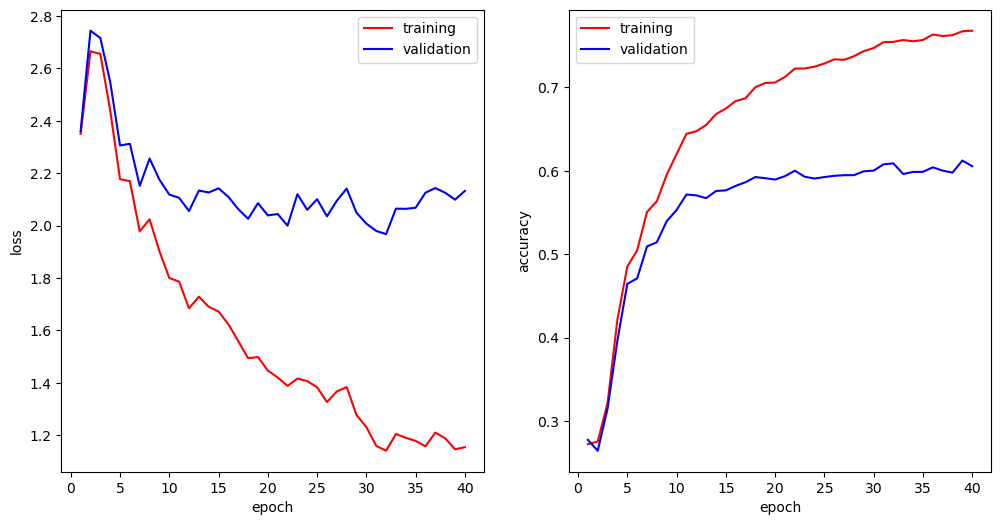

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.4675, Accuracy = 0.8213
client 2 : Loss = 0.2286, Accuracy = 0.9122
client 3 : Loss = 0.3177, Accuracy = 0.8831
client 4 : Loss = 0.2815, Accuracy = 0.8935
client 5 : Loss = 0.2599, Accuracy = 0.9056
client 6 : Loss = 0.2019, Accuracy = 0.9256
client 7 : Loss = 0.4990, Accuracy = 0.8187
client 8 : Loss = 0.4415, Accuracy = 0.8105

Server :
    - training loss = 2.4343
    - training accuracy = 0.2450
    - validation loss = 2.4632
    - validation accuracy = 0.2412
        
>>> Round 2 ...
client 1 : Loss = 0.3850, Accuracy = 0.8549
client 2 : Loss = 0.2142, Accuracy = 0.9167
client 3 : Loss = 0.3539, Accuracy = 0.8703
client 4 : Loss = 0.2004, Accuracy = 0.9265
client 5 : Loss = 0.1578, Accuracy = 0.9472
client 6 : Loss = 0.1725, Accuracy = 0.9373
cli

client 6 : Loss = 0.0133, Accuracy = 0.9988
client 7 : Loss = 0.0180, Accuracy = 0.9983
client 8 : Loss = 0.0058, Accuracy = 0.9995

Server :
    - training loss = 1.1494
    - training accuracy = 0.6980
    - validation loss = 1.5726
    - validation accuracy = 0.6018
        
>>> Round 17 ...
client 1 : Loss = 0.0103, Accuracy = 0.9993
client 2 : Loss = 0.0153, Accuracy = 0.9966
client 3 : Loss = 0.0144, Accuracy = 0.9976
client 4 : Loss = 0.0066, Accuracy = 0.9991
client 5 : Loss = 0.0056, Accuracy = 0.9995
client 6 : Loss = 0.0083, Accuracy = 1.0000
client 7 : Loss = 0.0184, Accuracy = 0.9978
client 8 : Loss = 0.0055, Accuracy = 0.9992

Server :
    - training loss = 1.1067
    - training accuracy = 0.7082
    - validation loss = 1.5618
    - validation accuracy = 0.6105
        
>>> Round 18 ...
client 1 : Loss = 0.0100, Accuracy = 0.9996
client 2 : Loss = 0.0201, Accuracy = 0.9947
client 3 : Loss = 0.0138, Accuracy = 0.9983
client 4 : Loss = 0.0056, Accuracy = 0.9998
client 5 : L

client 5 : Loss = 0.0060, Accuracy = 0.9985
client 6 : Loss = 0.0078, Accuracy = 0.9982
client 7 : Loss = 0.0090, Accuracy = 0.9973
client 8 : Loss = 0.0025, Accuracy = 0.9999

Server :
    - training loss = 0.8941
    - training accuracy = 0.7689
    - validation loss = 1.6666
    - validation accuracy = 0.6190
        
>>> Round 33 ...
client 1 : Loss = 0.0042, Accuracy = 0.9991
client 2 : Loss = 0.0048, Accuracy = 0.9991
client 3 : Loss = 0.0091, Accuracy = 0.9976
client 4 : Loss = 0.0018, Accuracy = 0.9998
client 5 : Loss = 0.0032, Accuracy = 0.9995
client 6 : Loss = 0.0045, Accuracy = 0.9994
client 7 : Loss = 0.0061, Accuracy = 0.9998
client 8 : Loss = 0.0039, Accuracy = 0.9991

Server :
    - training loss = 0.9171
    - training accuracy = 0.7689
    - validation loss = 1.7123
    - validation accuracy = 0.6193
        
>>> Round 34 ...
client 1 : Loss = 0.0049, Accuracy = 0.9988
client 2 : Loss = 0.0173, Accuracy = 0.9963
client 3 : Loss = 0.0080, Accuracy = 0.9980
client 4 : L

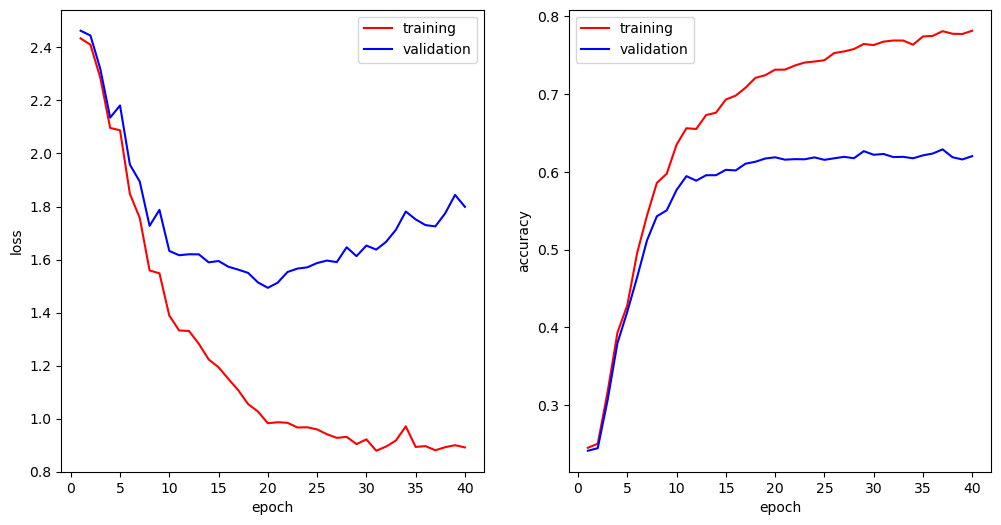

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.6205, Accuracy = 0.7572
client 2 : Loss = 0.1634, Accuracy = 0.9436
client 3 : Loss = 0.2443, Accuracy = 0.9138
client 4 : Loss = 0.4148, Accuracy = 0.8424
client 5 : Loss = 0.1304, Accuracy = 0.9639
client 6 : Loss = 0.1385, Accuracy = 0.9628
client 7 : Loss = 0.4314, Accuracy = 0.8466
client 8 : Loss = 0.4906, Accuracy = 0.7938

Server :
    - training loss = 2.0305
    - training accuracy = 0.2827
    - validation loss = 2.0866
    - validation accuracy = 0.2745
        
>>> Round 2 ...
client 1 : Loss = 0.5231, Accuracy = 0.7977
client 2 : Loss = 0.1386, Accuracy = 0.9533
client 3 : Loss = 0.1978, Accuracy = 0.9391
client 4 : Loss = 0.3332, Accuracy = 0.8780
client 5 : Loss = 0.1082, Accuracy = 0.9746
client 6 : Loss = 0.1086, Accuracy = 0.9751
cli

client 6 : Loss = 0.0533, Accuracy = 0.9916
client 7 : Loss = 0.0724, Accuracy = 0.9848
client 8 : Loss = 0.0417, Accuracy = 0.9932

Server :
    - training loss = 1.0719
    - training accuracy = 0.6249
    - validation loss = 1.6699
    - validation accuracy = 0.4607
        
>>> Round 17 ...
client 1 : Loss = 0.1157, Accuracy = 0.9646
client 2 : Loss = 0.0405, Accuracy = 0.9920
client 3 : Loss = 0.0535, Accuracy = 0.9885
client 4 : Loss = 0.0323, Accuracy = 0.9958
client 5 : Loss = 0.0275, Accuracy = 0.9946
client 6 : Loss = 0.0456, Accuracy = 0.9922
client 7 : Loss = 0.0720, Accuracy = 0.9840
client 8 : Loss = 0.0322, Accuracy = 0.9954

Server :
    - training loss = 1.0218
    - training accuracy = 0.6403
    - validation loss = 1.6422
    - validation accuracy = 0.4701
        
>>> Round 18 ...
client 1 : Loss = 0.1156, Accuracy = 0.9712
client 2 : Loss = 0.0368, Accuracy = 0.9929
client 3 : Loss = 0.0481, Accuracy = 0.9886
client 4 : Loss = 0.0308, Accuracy = 0.9962
client 5 : L

client 5 : Loss = 0.0146, Accuracy = 0.9995
client 6 : Loss = 0.0331, Accuracy = 0.9934
client 7 : Loss = 0.0279, Accuracy = 0.9951
client 8 : Loss = 0.0077, Accuracy = 0.9993

Server :
    - training loss = 0.7485
    - training accuracy = 0.7340
    - validation loss = 1.7317
    - validation accuracy = 0.4834
        
>>> Round 33 ...
client 1 : Loss = 0.0286, Accuracy = 0.9962
client 2 : Loss = 0.0230, Accuracy = 0.9958
client 3 : Loss = 0.0240, Accuracy = 0.9959
client 4 : Loss = 0.0115, Accuracy = 0.9988
client 5 : Loss = 0.0146, Accuracy = 0.9976
client 6 : Loss = 0.0293, Accuracy = 0.9976
client 7 : Loss = 0.0240, Accuracy = 0.9966
client 8 : Loss = 0.0068, Accuracy = 0.9996

Server :
    - training loss = 0.7411
    - training accuracy = 0.7393
    - validation loss = 1.7235
    - validation accuracy = 0.4849
        
>>> Round 34 ...
client 1 : Loss = 0.0570, Accuracy = 0.9810
client 2 : Loss = 0.0170, Accuracy = 0.9975
client 3 : Loss = 0.0251, Accuracy = 0.9956
client 4 : L

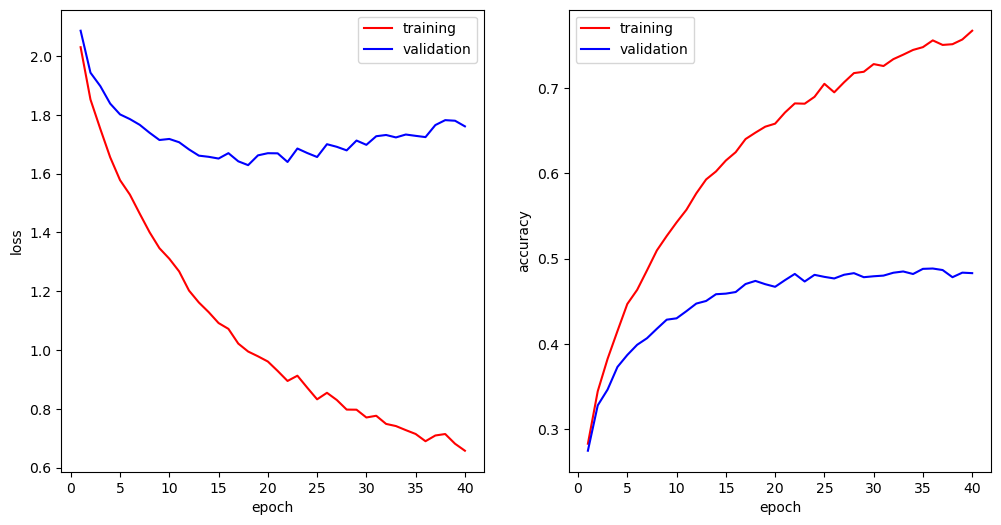

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.5048, Accuracy = 0.8078
client 2 : Loss = 0.1650, Accuracy = 0.9418
client 3 : Loss = 0.2748, Accuracy = 0.9063
client 4 : Loss = 0.4231, Accuracy = 0.8460
client 5 : Loss = 0.3130, Accuracy = 0.9113
client 6 : Loss = 0.1276, Accuracy = 0.9679
client 7 : Loss = 0.4620, Accuracy = 0.8518
client 8 : Loss = 0.4851, Accuracy = 0.7986

Server :
    - training loss = 2.0601
    - training accuracy = 0.2698
    - validation loss = 2.1028
    - validation accuracy = 0.2581
        
>>> Round 2 ...
client 1 : Loss = 0.4296, Accuracy = 0.8391
client 2 : Loss = 0.1389, Accuracy = 0.9558
client 3 : Loss = 0.2287, Accuracy = 0.9254
client 4 : Loss = 0.3288, Accuracy = 0.8803
client 5 : Loss = 0.1604, Accuracy = 0.9511
client 6 : Loss = 0.1182, Accuracy = 0.9738
cli

client 6 : Loss = 0.0467, Accuracy = 0.9940
client 7 : Loss = 0.0708, Accuracy = 0.9846
client 8 : Loss = 0.0359, Accuracy = 0.9943

Server :
    - training loss = 1.0646
    - training accuracy = 0.6303
    - validation loss = 1.6754
    - validation accuracy = 0.4696
        
>>> Round 17 ...
client 1 : Loss = 0.0512, Accuracy = 0.9924
client 2 : Loss = 0.0402, Accuracy = 0.9906
client 3 : Loss = 0.0507, Accuracy = 0.9879
client 4 : Loss = 0.0369, Accuracy = 0.9931
client 5 : Loss = 0.0381, Accuracy = 0.9954
client 6 : Loss = 0.0509, Accuracy = 0.9921
client 7 : Loss = 0.0638, Accuracy = 0.9868
client 8 : Loss = 0.0309, Accuracy = 0.9948

Server :
    - training loss = 1.0503
    - training accuracy = 0.6346
    - validation loss = 1.6726
    - validation accuracy = 0.4735
        
>>> Round 18 ...
client 1 : Loss = 0.0433, Accuracy = 0.9929
client 2 : Loss = 0.0357, Accuracy = 0.9931
client 3 : Loss = 0.0594, Accuracy = 0.9881
client 4 : Loss = 0.0295, Accuracy = 0.9956
client 5 : L

client 5 : Loss = 0.0470, Accuracy = 0.9899
client 6 : Loss = 0.0392, Accuracy = 0.9934
client 7 : Loss = 0.0283, Accuracy = 0.9962
client 8 : Loss = 0.0078, Accuracy = 0.9993

Server :
    - training loss = 0.7562
    - training accuracy = 0.7376
    - validation loss = 1.7332
    - validation accuracy = 0.4899
        
>>> Round 33 ...
client 1 : Loss = 0.0147, Accuracy = 0.9988
client 2 : Loss = 0.0186, Accuracy = 0.9960
client 3 : Loss = 0.0293, Accuracy = 0.9942
client 4 : Loss = 0.0113, Accuracy = 0.9985
client 5 : Loss = 0.1976, Accuracy = 0.9461
client 6 : Loss = 0.0354, Accuracy = 0.9957
client 7 : Loss = 0.0262, Accuracy = 0.9958
client 8 : Loss = 0.0074, Accuracy = 0.9994

Server :
    - training loss = 0.7451
    - training accuracy = 0.7417
    - validation loss = 1.7374
    - validation accuracy = 0.4862
        
>>> Round 34 ...
client 1 : Loss = 0.0136, Accuracy = 0.9987
client 2 : Loss = 0.0150, Accuracy = 0.9976
client 3 : Loss = 0.0293, Accuracy = 0.9949
client 4 : L

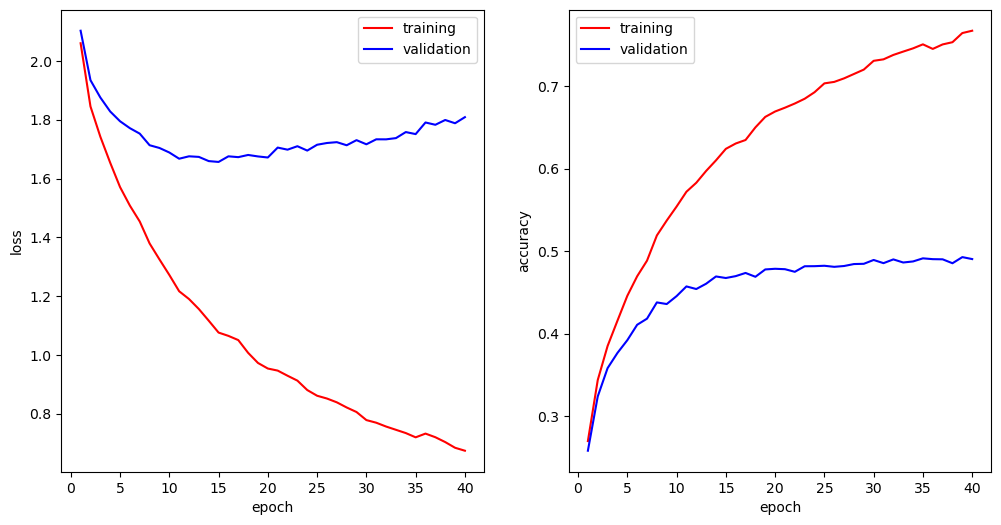

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.4944, Accuracy = 0.8122
client 2 : Loss = 0.1662, Accuracy = 0.9335
client 3 : Loss = 0.2557, Accuracy = 0.9163
client 4 : Loss = 0.4185, Accuracy = 0.8428
client 5 : Loss = 0.1725, Accuracy = 0.9418
client 6 : Loss = 0.1289, Accuracy = 0.9669
client 7 : Loss = 0.4252, Accuracy = 0.8529
client 8 : Loss = 0.4831, Accuracy = 0.7987

Server :
    - training loss = 1.9943
    - training accuracy = 0.2796
    - validation loss = 2.0549
    - validation accuracy = 0.2589
        
>>> Round 2 ...
client 1 : Loss = 0.4066, Accuracy = 0.8513
client 2 : Loss = 0.1415, Accuracy = 0.9515
client 3 : Loss = 0.2028, Accuracy = 0.9364
client 4 : Loss = 0.3190, Accuracy = 0.8797
client 5 : Loss = 0.1276, Accuracy = 0.9660
client 6 : Loss = 0.1066, Accuracy = 0.9756
cli

client 6 : Loss = 0.0427, Accuracy = 0.9966
client 7 : Loss = 0.0702, Accuracy = 0.9858
client 8 : Loss = 0.0350, Accuracy = 0.9951

Server :
    - training loss = 1.0472
    - training accuracy = 0.6375
    - validation loss = 1.6761
    - validation accuracy = 0.4552
        
>>> Round 17 ...
client 1 : Loss = 0.0477, Accuracy = 0.9932
client 2 : Loss = 0.0394, Accuracy = 0.9937
client 3 : Loss = 0.0572, Accuracy = 0.9888
client 4 : Loss = 0.0366, Accuracy = 0.9946
client 5 : Loss = 0.0445, Accuracy = 0.9908
client 6 : Loss = 0.0531, Accuracy = 0.9908
client 7 : Loss = 0.0719, Accuracy = 0.9839
client 8 : Loss = 0.0308, Accuracy = 0.9955

Server :
    - training loss = 1.0006
    - training accuracy = 0.6512
    - validation loss = 1.6629
    - validation accuracy = 0.4566
        
>>> Round 18 ...
client 1 : Loss = 0.0451, Accuracy = 0.9933
client 2 : Loss = 0.0322, Accuracy = 0.9961
client 3 : Loss = 0.0507, Accuracy = 0.9898
client 4 : Loss = 0.0422, Accuracy = 0.9900
client 5 : L

client 5 : Loss = 0.0298, Accuracy = 0.9931
client 6 : Loss = 0.0362, Accuracy = 0.9922
client 7 : Loss = 0.0291, Accuracy = 0.9951
client 8 : Loss = 0.0068, Accuracy = 0.9995

Server :
    - training loss = 0.7514
    - training accuracy = 0.7391
    - validation loss = 1.7600
    - validation accuracy = 0.4764
        
>>> Round 33 ...
client 1 : Loss = 0.0140, Accuracy = 0.9983
client 2 : Loss = 0.0200, Accuracy = 0.9972
client 3 : Loss = 0.0256, Accuracy = 0.9952
client 4 : Loss = 0.0206, Accuracy = 0.9935
client 5 : Loss = 0.0314, Accuracy = 0.9889
client 6 : Loss = 0.0336, Accuracy = 0.9938
client 7 : Loss = 0.0229, Accuracy = 0.9961
client 8 : Loss = 0.0065, Accuracy = 0.9996

Server :
    - training loss = 0.7695
    - training accuracy = 0.7367
    - validation loss = 1.7816
    - validation accuracy = 0.4764
        
>>> Round 34 ...
client 1 : Loss = 0.0155, Accuracy = 0.9984
client 2 : Loss = 0.0191, Accuracy = 0.9975
client 3 : Loss = 0.0251, Accuracy = 0.9959
client 4 : L

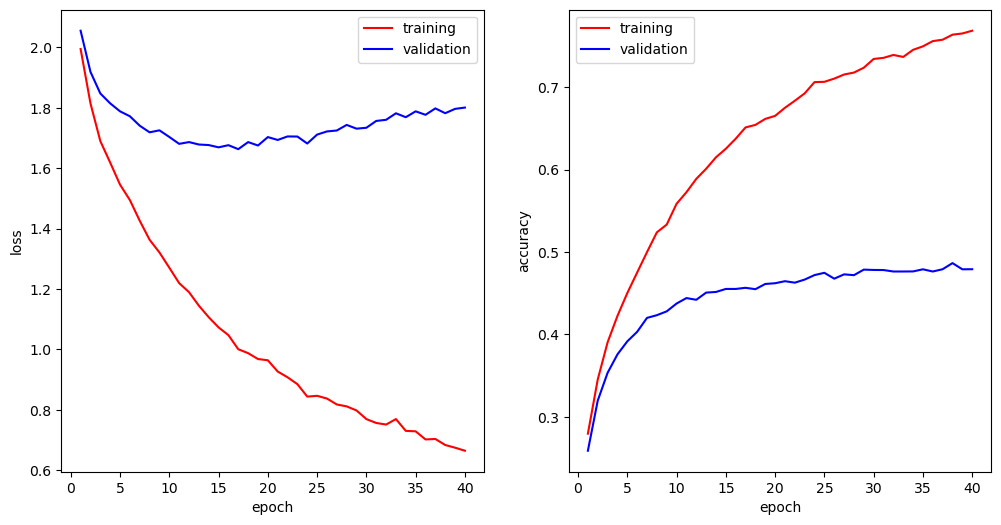

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.5288, Accuracy = 0.7929
client 2 : Loss = 0.1741, Accuracy = 0.9376
client 3 : Loss = 0.2909, Accuracy = 0.9039
client 4 : Loss = 0.4110, Accuracy = 0.8442
client 5 : Loss = 0.1619, Accuracy = 0.9501
client 6 : Loss = 0.1318, Accuracy = 0.9657
client 7 : Loss = 0.4493, Accuracy = 0.8396
client 8 : Loss = 0.4912, Accuracy = 0.7961

Server :
    - training loss = 2.0321
    - training accuracy = 0.2733
    - validation loss = 2.0946
    - validation accuracy = 0.2564
        
>>> Round 2 ...
client 1 : Loss = 0.4435, Accuracy = 0.8334
client 2 : Loss = 0.1457, Accuracy = 0.9514
client 3 : Loss = 0.2332, Accuracy = 0.9236
client 4 : Loss = 0.3275, Accuracy = 0.8801
client 5 : Loss = 0.1466, Accuracy = 0.9601
client 6 : Loss = 0.1153, Accuracy = 0.9737
cli

client 6 : Loss = 0.0538, Accuracy = 0.9919
client 7 : Loss = 0.0770, Accuracy = 0.9810
client 8 : Loss = 0.0396, Accuracy = 0.9934

Server :
    - training loss = 1.0464
    - training accuracy = 0.6362
    - validation loss = 1.6742
    - validation accuracy = 0.4671
        
>>> Round 17 ...
client 1 : Loss = 0.0527, Accuracy = 0.9908
client 2 : Loss = 0.0412, Accuracy = 0.9910
client 3 : Loss = 0.0775, Accuracy = 0.9769
client 4 : Loss = 0.0329, Accuracy = 0.9955
client 5 : Loss = 0.0572, Accuracy = 0.9844
client 6 : Loss = 0.0479, Accuracy = 0.9925
client 7 : Loss = 0.0655, Accuracy = 0.9880
client 8 : Loss = 0.0317, Accuracy = 0.9956

Server :
    - training loss = 1.0006
    - training accuracy = 0.6511
    - validation loss = 1.6700
    - validation accuracy = 0.4655
        
>>> Round 18 ...
client 1 : Loss = 0.0475, Accuracy = 0.9920
client 2 : Loss = 0.0351, Accuracy = 0.9931
client 3 : Loss = 0.0599, Accuracy = 0.9874
client 4 : Loss = 0.0294, Accuracy = 0.9961
client 5 : L

client 5 : Loss = 0.0402, Accuracy = 0.9899
client 6 : Loss = 0.0372, Accuracy = 0.9928
client 7 : Loss = 0.0255, Accuracy = 0.9951
client 8 : Loss = 0.0081, Accuracy = 0.9991

Server :
    - training loss = 0.7508
    - training accuracy = 0.7385
    - validation loss = 1.7593
    - validation accuracy = 0.4821
        
>>> Round 33 ...
client 1 : Loss = 0.0155, Accuracy = 0.9980
client 2 : Loss = 0.0172, Accuracy = 0.9982
client 3 : Loss = 0.0580, Accuracy = 0.9830
client 4 : Loss = 0.0094, Accuracy = 0.9996
client 5 : Loss = 0.0375, Accuracy = 0.9931
client 6 : Loss = 0.0300, Accuracy = 0.9964
client 7 : Loss = 0.0257, Accuracy = 0.9956
client 8 : Loss = 0.0077, Accuracy = 0.9991

Server :
    - training loss = 0.7445
    - training accuracy = 0.7407
    - validation loss = 1.7656
    - validation accuracy = 0.4786
        
>>> Round 34 ...
client 1 : Loss = 0.0142, Accuracy = 0.9986
client 2 : Loss = 0.0209, Accuracy = 0.9958
client 3 : Loss = 0.0851, Accuracy = 0.9701
client 4 : L

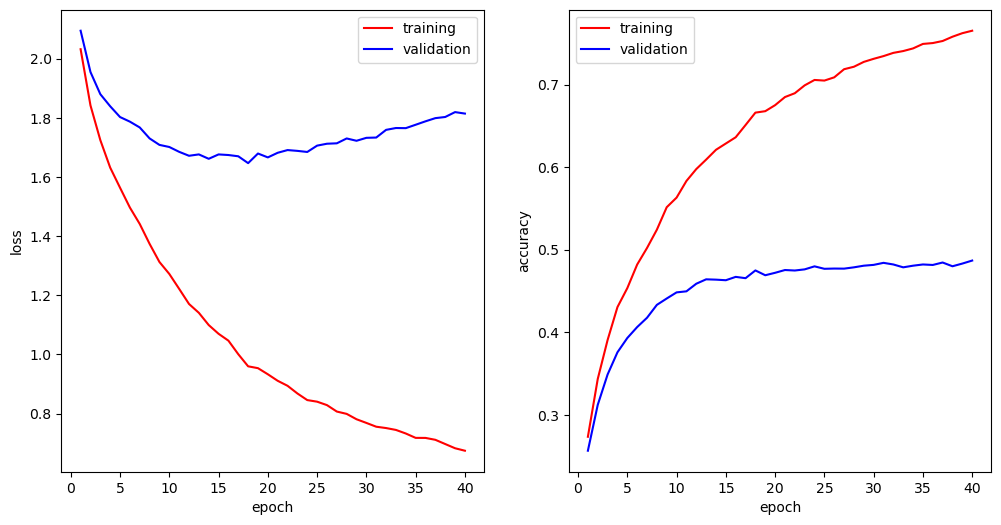

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.5073, Accuracy = 0.8098
client 2 : Loss = 0.1708, Accuracy = 0.9380
client 3 : Loss = 0.2660, Accuracy = 0.9122
client 4 : Loss = 0.3858, Accuracy = 0.8554
client 5 : Loss = 0.1321, Accuracy = 0.9589
client 6 : Loss = 0.1399, Accuracy = 0.9583
client 7 : Loss = 0.4036, Accuracy = 0.8690
client 8 : Loss = 0.4820, Accuracy = 0.7988

Server :
    - training loss = 2.0313
    - training accuracy = 0.2705
    - validation loss = 2.1048
    - validation accuracy = 0.2469
        
>>> Round 2 ...
client 1 : Loss = 0.4238, Accuracy = 0.8432
client 2 : Loss = 0.1515, Accuracy = 0.9490
client 3 : Loss = 0.1916, Accuracy = 0.9420
client 4 : Loss = 0.3009, Accuracy = 0.8888
client 5 : Loss = 0.1048, Accuracy = 0.9727
client 6 : Loss = 0.1040, Accuracy = 0.9765
cli

client 6 : Loss = 0.0422, Accuracy = 0.9946
client 7 : Loss = 0.0633, Accuracy = 0.9885
client 8 : Loss = 0.0338, Accuracy = 0.9942

Server :
    - training loss = 1.0290
    - training accuracy = 0.6396
    - validation loss = 1.6712
    - validation accuracy = 0.4597
        
>>> Round 17 ...
client 1 : Loss = 0.0506, Accuracy = 0.9904
client 2 : Loss = 0.0439, Accuracy = 0.9897
client 3 : Loss = 0.0559, Accuracy = 0.9869
client 4 : Loss = 0.0297, Accuracy = 0.9964
client 5 : Loss = 0.0256, Accuracy = 0.9956
client 6 : Loss = 0.0445, Accuracy = 0.9914
client 7 : Loss = 0.0614, Accuracy = 0.9871
client 8 : Loss = 0.0303, Accuracy = 0.9955

Server :
    - training loss = 1.0032
    - training accuracy = 0.6504
    - validation loss = 1.6628
    - validation accuracy = 0.4611
        
>>> Round 18 ...
client 1 : Loss = 0.0420, Accuracy = 0.9943
client 2 : Loss = 0.0370, Accuracy = 0.9926
client 3 : Loss = 0.0514, Accuracy = 0.9898
client 4 : Loss = 0.0265, Accuracy = 0.9965
client 5 : L

client 5 : Loss = 0.0180, Accuracy = 0.9976
client 6 : Loss = 0.0390, Accuracy = 0.9928
client 7 : Loss = 0.0240, Accuracy = 0.9965
client 8 : Loss = 0.0068, Accuracy = 0.9996

Server :
    - training loss = 0.7562
    - training accuracy = 0.7372
    - validation loss = 1.7711
    - validation accuracy = 0.4755
        
>>> Round 33 ...
client 1 : Loss = 0.0136, Accuracy = 0.9986
client 2 : Loss = 0.0168, Accuracy = 0.9982
client 3 : Loss = 0.0268, Accuracy = 0.9956
client 4 : Loss = 0.0092, Accuracy = 0.9991
client 5 : Loss = 0.0144, Accuracy = 0.9985
client 6 : Loss = 0.0327, Accuracy = 0.9934
client 7 : Loss = 0.0238, Accuracy = 0.9961
client 8 : Loss = 0.0080, Accuracy = 0.9991

Server :
    - training loss = 0.7540
    - training accuracy = 0.7397
    - validation loss = 1.7922
    - validation accuracy = 0.4735
        
>>> Round 34 ...
client 1 : Loss = 0.0143, Accuracy = 0.9984
client 2 : Loss = 0.0186, Accuracy = 0.9972
client 3 : Loss = 0.0303, Accuracy = 0.9946
client 4 : L

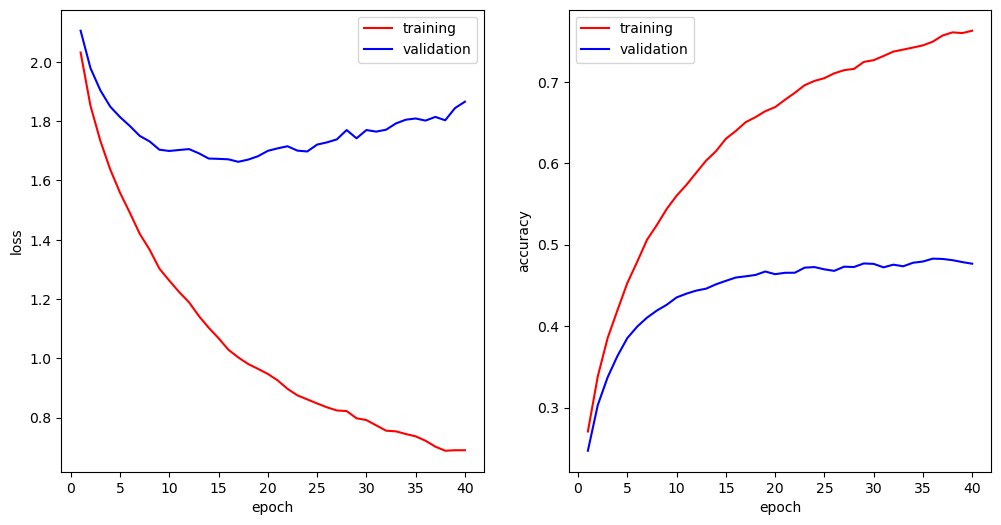

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 1.4967, Accuracy = 0.4932
client 2 : Loss = 0.9988, Accuracy = 0.6909
client 3 : Loss = 1.1482, Accuracy = 0.6819
client 4 : Loss = 1.5124, Accuracy = 0.5346
client 5 : Loss = 1.0294, Accuracy = 0.7000
client 6 : Loss = 1.5028, Accuracy = 0.5225
client 7 : Loss = 1.5789, Accuracy = 0.5139
client 8 : Loss = 1.2666, Accuracy = 0.5814

Server :
    - training loss = 2.3717
    - training accuracy = 0.1663
    - validation loss = 2.3775
    - validation accuracy = 0.1650
        
>>> Round 2 ...
client 1 : Loss = 1.3788, Accuracy = 0.5303
client 2 : Loss = 1.0056, Accuracy = 0.6890
client 3 : Loss = 1.0927, Accuracy = 0.7020
client 4 : Loss = 1.2838, Accuracy = 0.5947
client 5 : Loss = 0.9253, Accuracy = 0.7259
client 6 : Loss = 1.3892, Accuracy = 0.5754
cli

client 6 : Loss = 1.1600, Accuracy = 0.6423
client 7 : Loss = 0.8885, Accuracy = 0.7259
client 8 : Loss = 0.6704, Accuracy = 0.7420

Server :
    - training loss = 1.6826
    - training accuracy = 0.4111
    - validation loss = 1.8196
    - validation accuracy = 0.3624
        
>>> Round 17 ...
client 1 : Loss = 1.0126, Accuracy = 0.6632
client 2 : Loss = 1.3797, Accuracy = 0.6509
client 3 : Loss = 0.9347, Accuracy = 0.7621
client 4 : Loss = 0.7334, Accuracy = 0.7669
client 5 : Loss = 0.7071, Accuracy = 0.8114
client 6 : Loss = 1.1620, Accuracy = 0.6479
client 7 : Loss = 0.9004, Accuracy = 0.7237
client 8 : Loss = 0.6524, Accuracy = 0.7467

Server :
    - training loss = 1.6713
    - training accuracy = 0.4154
    - validation loss = 1.8092
    - validation accuracy = 0.3636
        
>>> Round 18 ...
client 1 : Loss = 1.0061, Accuracy = 0.6687
client 2 : Loss = 1.4039, Accuracy = 0.6599
client 3 : Loss = 0.9288, Accuracy = 0.7645
client 4 : Loss = 0.7159, Accuracy = 0.7649
client 5 : L

client 5 : Loss = 0.5887, Accuracy = 0.8481
client 6 : Loss = 1.0385, Accuracy = 0.6860
client 7 : Loss = 0.7261, Accuracy = 0.7789
client 8 : Loss = 0.5171, Accuracy = 0.8065

Server :
    - training loss = 1.5003
    - training accuracy = 0.4847
    - validation loss = 1.7289
    - validation accuracy = 0.4044
        
>>> Round 33 ...
client 1 : Loss = 0.8148, Accuracy = 0.7298
client 2 : Loss = 1.2291, Accuracy = 0.7218
client 3 : Loss = 0.7994, Accuracy = 0.7968
client 4 : Loss = 0.5757, Accuracy = 0.8263
client 5 : Loss = 0.5588, Accuracy = 0.8584
client 6 : Loss = 1.0508, Accuracy = 0.6690
client 7 : Loss = 0.7196, Accuracy = 0.7724
client 8 : Loss = 0.4993, Accuracy = 0.8126

Server :
    - training loss = 1.4914
    - training accuracy = 0.4875
    - validation loss = 1.7190
    - validation accuracy = 0.4049
        
>>> Round 34 ...
client 1 : Loss = 0.8504, Accuracy = 0.7193
client 2 : Loss = 1.2202, Accuracy = 0.7222
client 3 : Loss = 0.8182, Accuracy = 0.7931
client 4 : L

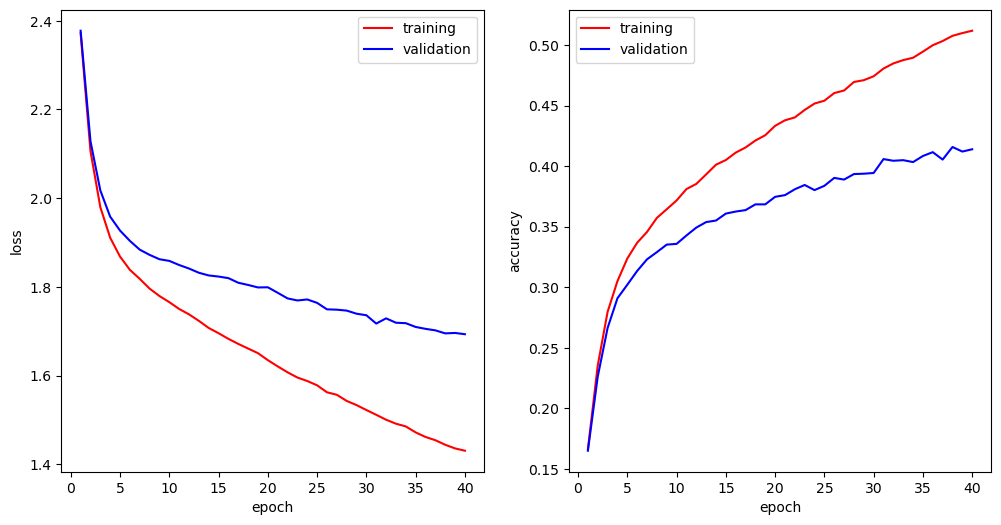

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 1.5471, Accuracy = 0.5073
client 2 : Loss = 1.3666, Accuracy = 0.5830
client 3 : Loss = 1.2388, Accuracy = 0.6637
client 4 : Loss = 1.1659, Accuracy = 0.5938
client 5 : Loss = 1.1652, Accuracy = 0.6529
client 6 : Loss = 1.9887, Accuracy = 0.3767
client 7 : Loss = 1.4660, Accuracy = 0.5468
client 8 : Loss = 1.0843, Accuracy = 0.6168

Server :
    - training loss = 2.3064
    - training accuracy = 0.1830
    - validation loss = 2.3142
    - validation accuracy = 0.1765
        
>>> Round 2 ...
client 1 : Loss = 1.4534, Accuracy = 0.5355
client 2 : Loss = 1.3770, Accuracy = 0.5957
client 3 : Loss = 1.2189, Accuracy = 0.6913
client 4 : Loss = 1.1034, Accuracy = 0.6193
client 5 : Loss = 1.0854, Accuracy = 0.6756
client 6 : Loss = 1.8116, Accuracy = 0.4252
cli

client 6 : Loss = 1.1109, Accuracy = 0.6474
client 7 : Loss = 0.9104, Accuracy = 0.7156
client 8 : Loss = 0.6361, Accuracy = 0.7620

Server :
    - training loss = 1.6621
    - training accuracy = 0.4201
    - validation loss = 1.7953
    - validation accuracy = 0.3741
        
>>> Round 17 ...
client 1 : Loss = 0.9657, Accuracy = 0.6910
client 2 : Loss = 1.4352, Accuracy = 0.6572
client 3 : Loss = 0.9540, Accuracy = 0.7604
client 4 : Loss = 0.6928, Accuracy = 0.7802
client 5 : Loss = 0.9090, Accuracy = 0.7595
client 6 : Loss = 1.1053, Accuracy = 0.6608
client 7 : Loss = 0.9025, Accuracy = 0.7196
client 8 : Loss = 0.6298, Accuracy = 0.7603

Server :
    - training loss = 1.6487
    - training accuracy = 0.4247
    - validation loss = 1.7881
    - validation accuracy = 0.3801
        
>>> Round 18 ...
client 1 : Loss = 0.9583, Accuracy = 0.6871
client 2 : Loss = 1.3683, Accuracy = 0.6702
client 3 : Loss = 0.9526, Accuracy = 0.7614
client 4 : Loss = 0.6835, Accuracy = 0.7777
client 5 : L

client 5 : Loss = 0.6884, Accuracy = 0.8028
client 6 : Loss = 0.9418, Accuracy = 0.7060
client 7 : Loss = 0.7323, Accuracy = 0.7720
client 8 : Loss = 0.4878, Accuracy = 0.8178

Server :
    - training loss = 1.4707
    - training accuracy = 0.4963
    - validation loss = 1.6964
    - validation accuracy = 0.4141
        
>>> Round 33 ...
client 1 : Loss = 0.7517, Accuracy = 0.7577
client 2 : Loss = 1.1628, Accuracy = 0.7412
client 3 : Loss = 0.7921, Accuracy = 0.8016
client 4 : Loss = 0.5314, Accuracy = 0.8385
client 5 : Loss = 0.6518, Accuracy = 0.8350
client 6 : Loss = 0.9410, Accuracy = 0.7263
client 7 : Loss = 0.7286, Accuracy = 0.7626
client 8 : Loss = 0.4912, Accuracy = 0.8195

Server :
    - training loss = 1.4617
    - training accuracy = 0.5000
    - validation loss = 1.6925
    - validation accuracy = 0.4121
        
>>> Round 34 ...
client 1 : Loss = 0.7613, Accuracy = 0.7506
client 2 : Loss = 1.1402, Accuracy = 0.7508
client 3 : Loss = 0.8146, Accuracy = 0.7924
client 4 : L

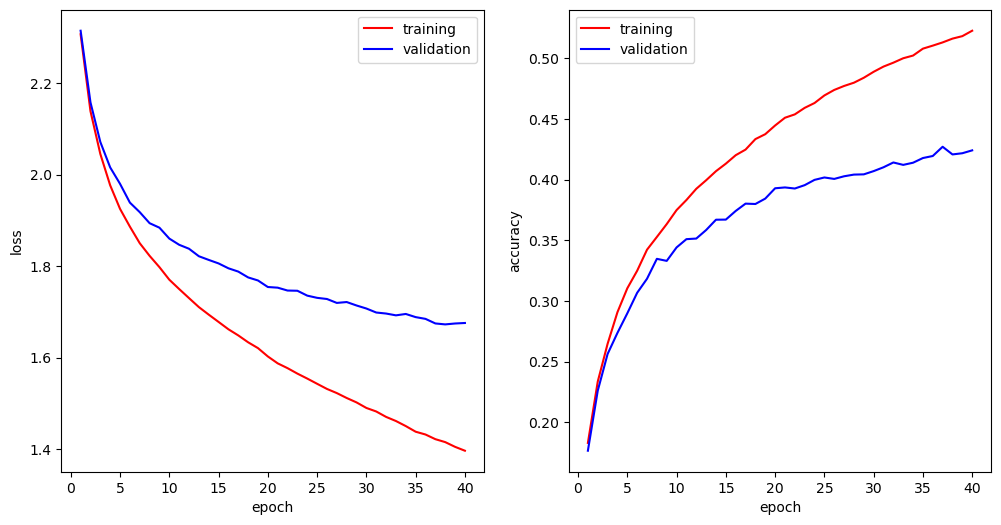

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 1.4696, Accuracy = 0.5089
client 2 : Loss = 0.9926, Accuracy = 0.7251
client 3 : Loss = 1.3682, Accuracy = 0.6344
client 4 : Loss = 1.4415, Accuracy = 0.5312
client 5 : Loss = 0.9747, Accuracy = 0.7182
client 6 : Loss = 1.9260, Accuracy = 0.3894
client 7 : Loss = 1.3904, Accuracy = 0.5570
client 8 : Loss = 1.0777, Accuracy = 0.6127

Server :
    - training loss = 2.2752
    - training accuracy = 0.1853
    - validation loss = 2.2897
    - validation accuracy = 0.1767
        
>>> Round 2 ...
client 1 : Loss = 1.3705, Accuracy = 0.5486
client 2 : Loss = 1.0179, Accuracy = 0.7061
client 3 : Loss = 1.2799, Accuracy = 0.6755
client 4 : Loss = 1.2762, Accuracy = 0.5742
client 5 : Loss = 0.9599, Accuracy = 0.7245
client 6 : Loss = 1.6895, Accuracy = 0.4535
cli

client 6 : Loss = 1.1665, Accuracy = 0.6270
client 7 : Loss = 0.8520, Accuracy = 0.7171
client 8 : Loss = 0.6396, Accuracy = 0.7540

Server :
    - training loss = 1.6579
    - training accuracy = 0.4169
    - validation loss = 1.8109
    - validation accuracy = 0.3671
        
>>> Round 17 ...
client 1 : Loss = 0.9291, Accuracy = 0.6943
client 2 : Loss = 1.3441, Accuracy = 0.6917
client 3 : Loss = 0.9534, Accuracy = 0.7584
client 4 : Loss = 0.7627, Accuracy = 0.7517
client 5 : Loss = 0.8844, Accuracy = 0.7577
client 6 : Loss = 1.1776, Accuracy = 0.6258
client 7 : Loss = 0.8200, Accuracy = 0.7372
client 8 : Loss = 0.6380, Accuracy = 0.7550

Server :
    - training loss = 1.6435
    - training accuracy = 0.4224
    - validation loss = 1.8010
    - validation accuracy = 0.3676
        
>>> Round 18 ...
client 1 : Loss = 0.9279, Accuracy = 0.6919
client 2 : Loss = 1.3459, Accuracy = 0.6856
client 3 : Loss = 0.9634, Accuracy = 0.7653
client 4 : Loss = 0.7628, Accuracy = 0.7519
client 5 : L

client 5 : Loss = 0.7643, Accuracy = 0.8205
client 6 : Loss = 1.0134, Accuracy = 0.6917
client 7 : Loss = 0.7055, Accuracy = 0.7746
client 8 : Loss = 0.4836, Accuracy = 0.8227

Server :
    - training loss = 1.4681
    - training accuracy = 0.4941
    - validation loss = 1.7192
    - validation accuracy = 0.4079
        
>>> Round 33 ...
client 1 : Loss = 0.7328, Accuracy = 0.7614
client 2 : Loss = 1.2101, Accuracy = 0.7555
client 3 : Loss = 0.8025, Accuracy = 0.8031
client 4 : Loss = 0.5926, Accuracy = 0.8153
client 5 : Loss = 0.6734, Accuracy = 0.8127
client 6 : Loss = 1.0439, Accuracy = 0.6685
client 7 : Loss = 0.6783, Accuracy = 0.7831
client 8 : Loss = 0.4766, Accuracy = 0.8256

Server :
    - training loss = 1.4560
    - training accuracy = 0.4979
    - validation loss = 1.7125
    - validation accuracy = 0.4112
        
>>> Round 34 ...
client 1 : Loss = 0.7226, Accuracy = 0.7650
client 2 : Loss = 1.2020, Accuracy = 0.7595
client 3 : Loss = 0.8291, Accuracy = 0.8056
client 4 : L

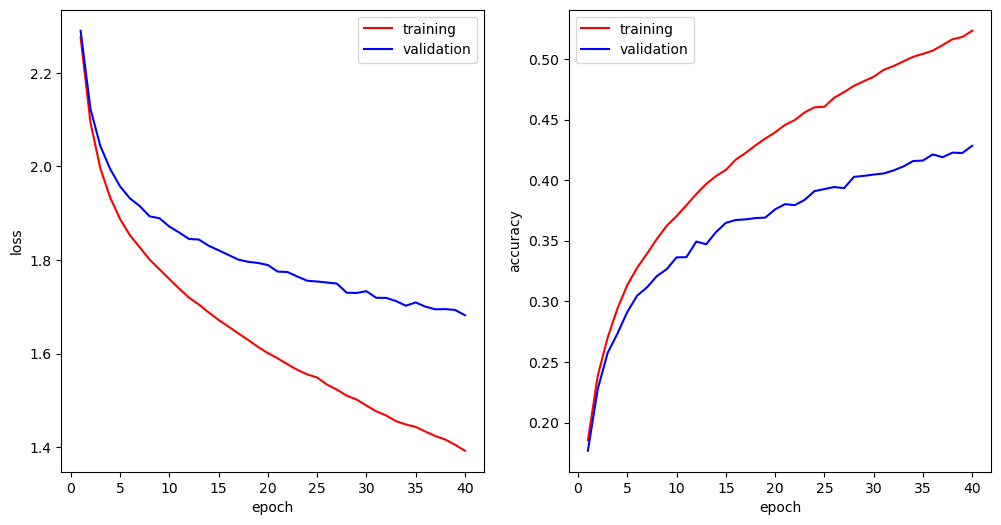

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 1.3391, Accuracy = 0.5343
client 2 : Loss = 1.1659, Accuracy = 0.6578
client 3 : Loss = 1.2137, Accuracy = 0.6824
client 4 : Loss = 1.3267, Accuracy = 0.5617
client 5 : Loss = 0.9745, Accuracy = 0.7228
client 6 : Loss = 1.3233, Accuracy = 0.5934
client 7 : Loss = 1.3603, Accuracy = 0.5635
client 8 : Loss = 1.1708, Accuracy = 0.5965

Server :
    - training loss = 2.2200
    - training accuracy = 0.1928
    - validation loss = 2.2560
    - validation accuracy = 0.1868
        
>>> Round 2 ...
client 1 : Loss = 1.2889, Accuracy = 0.5635
client 2 : Loss = 1.2137, Accuracy = 0.6644
client 3 : Loss = 1.1233, Accuracy = 0.7123
client 4 : Loss = 1.1975, Accuracy = 0.5992
client 5 : Loss = 0.8735, Accuracy = 0.7534
client 6 : Loss = 1.3167, Accuracy = 0.6133
cli

client 6 : Loss = 1.1466, Accuracy = 0.6393
client 7 : Loss = 0.8549, Accuracy = 0.7224
client 8 : Loss = 0.6591, Accuracy = 0.7461

Server :
    - training loss = 1.6630
    - training accuracy = 0.4147
    - validation loss = 1.8173
    - validation accuracy = 0.3600
        
>>> Round 17 ...
client 1 : Loss = 0.9663, Accuracy = 0.6821
client 2 : Loss = 1.2750, Accuracy = 0.7320
client 3 : Loss = 0.9393, Accuracy = 0.7772
client 4 : Loss = 0.7162, Accuracy = 0.7712
client 5 : Loss = 0.6738, Accuracy = 0.8165
client 6 : Loss = 1.1556, Accuracy = 0.6505
client 7 : Loss = 0.8423, Accuracy = 0.7363
client 8 : Loss = 0.6335, Accuracy = 0.7580

Server :
    - training loss = 1.6493
    - training accuracy = 0.4207
    - validation loss = 1.8098
    - validation accuracy = 0.3648
        
>>> Round 18 ...
client 1 : Loss = 0.9455, Accuracy = 0.6866
client 2 : Loss = 1.2435, Accuracy = 0.7386
client 3 : Loss = 0.9172, Accuracy = 0.7700
client 4 : Loss = 0.7107, Accuracy = 0.7726
client 5 : L

client 5 : Loss = 0.5909, Accuracy = 0.8426
client 6 : Loss = 1.0477, Accuracy = 0.6891
client 7 : Loss = 0.7047, Accuracy = 0.7766
client 8 : Loss = 0.4942, Accuracy = 0.8159

Server :
    - training loss = 1.4764
    - training accuracy = 0.4888
    - validation loss = 1.7182
    - validation accuracy = 0.4016
        
>>> Round 33 ...
client 1 : Loss = 0.7566, Accuracy = 0.7522
client 2 : Loss = 1.1001, Accuracy = 0.7919
client 3 : Loss = 0.8284, Accuracy = 0.8081
client 4 : Loss = 0.5476, Accuracy = 0.8342
client 5 : Loss = 0.5936, Accuracy = 0.8599
client 6 : Loss = 1.0280, Accuracy = 0.6882
client 7 : Loss = 0.6808, Accuracy = 0.7781
client 8 : Loss = 0.4826, Accuracy = 0.8219

Server :
    - training loss = 1.4665
    - training accuracy = 0.4913
    - validation loss = 1.7170
    - validation accuracy = 0.4016
        
>>> Round 34 ...
client 1 : Loss = 0.7583, Accuracy = 0.7529
client 2 : Loss = 1.1055, Accuracy = 0.7909
client 3 : Loss = 0.8264, Accuracy = 0.8084
client 4 : L

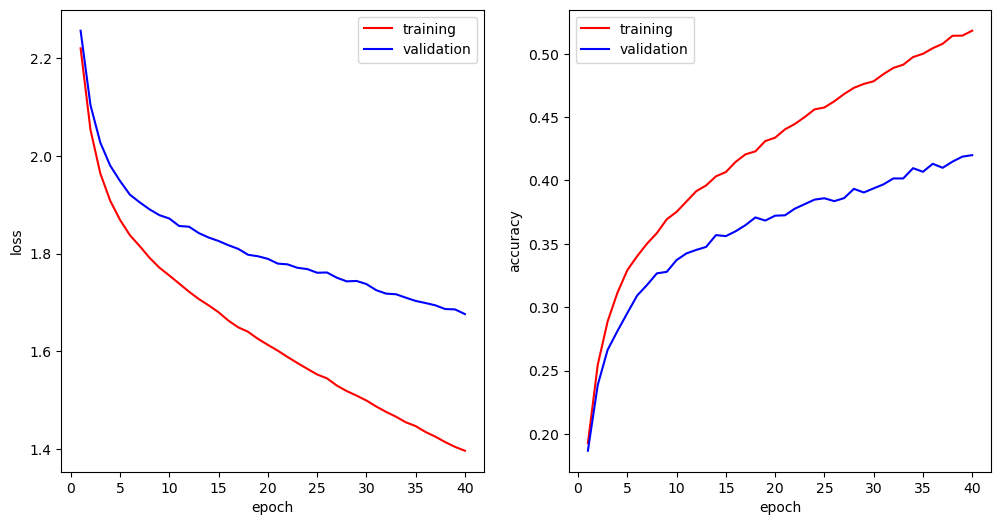

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 1.4218, Accuracy = 0.5296
client 2 : Loss = 1.4421, Accuracy = 0.5673
client 3 : Loss = 1.3978, Accuracy = 0.6533
client 4 : Loss = 1.2548, Accuracy = 0.5734
client 5 : Loss = 0.9938, Accuracy = 0.7047
client 6 : Loss = 1.7884, Accuracy = 0.4295
client 7 : Loss = 1.4230, Accuracy = 0.5495
client 8 : Loss = 1.0754, Accuracy = 0.6149

Server :
    - training loss = 2.2690
    - training accuracy = 0.1881
    - validation loss = 2.2824
    - validation accuracy = 0.1909
        
>>> Round 2 ...
client 1 : Loss = 1.3808, Accuracy = 0.5388
client 2 : Loss = 1.4343, Accuracy = 0.6007
client 3 : Loss = 1.3265, Accuracy = 0.6688
client 4 : Loss = 1.1319, Accuracy = 0.6167
client 5 : Loss = 0.9787, Accuracy = 0.7131
client 6 : Loss = 1.6577, Accuracy = 0.4710
cli

client 6 : Loss = 1.1797, Accuracy = 0.6396
client 7 : Loss = 0.8825, Accuracy = 0.7175
client 8 : Loss = 0.6351, Accuracy = 0.7550

Server :
    - training loss = 1.6709
    - training accuracy = 0.4232
    - validation loss = 1.8250
    - validation accuracy = 0.3635
        
>>> Round 17 ...
client 1 : Loss = 0.9676, Accuracy = 0.6854
client 2 : Loss = 1.3692, Accuracy = 0.7153
client 3 : Loss = 0.9660, Accuracy = 0.7606
client 4 : Loss = 0.7050, Accuracy = 0.7736
client 5 : Loss = 0.7262, Accuracy = 0.8045
client 6 : Loss = 1.1582, Accuracy = 0.6487
client 7 : Loss = 0.8768, Accuracy = 0.7151
client 8 : Loss = 0.6292, Accuracy = 0.7574

Server :
    - training loss = 1.6557
    - training accuracy = 0.4297
    - validation loss = 1.8163
    - validation accuracy = 0.3684
        
>>> Round 18 ...
client 1 : Loss = 0.9619, Accuracy = 0.6858
client 2 : Loss = 1.3391, Accuracy = 0.7219
client 3 : Loss = 0.8967, Accuracy = 0.7849
client 4 : Loss = 0.6936, Accuracy = 0.7754
client 5 : L

client 5 : Loss = 0.5820, Accuracy = 0.8471
client 6 : Loss = 1.0258, Accuracy = 0.6954
client 7 : Loss = 0.6980, Accuracy = 0.7794
client 8 : Loss = 0.4811, Accuracy = 0.8236

Server :
    - training loss = 1.4754
    - training accuracy = 0.4951
    - validation loss = 1.7203
    - validation accuracy = 0.4051
        
>>> Round 33 ...
client 1 : Loss = 0.7727, Accuracy = 0.7435
client 2 : Loss = 1.1617, Accuracy = 0.7758
client 3 : Loss = 0.7762, Accuracy = 0.8120
client 4 : Loss = 0.5319, Accuracy = 0.8362
client 5 : Loss = 0.5851, Accuracy = 0.8463
client 6 : Loss = 1.0229, Accuracy = 0.7064
client 7 : Loss = 0.6988, Accuracy = 0.7790
client 8 : Loss = 0.4777, Accuracy = 0.8243

Server :
    - training loss = 1.4658
    - training accuracy = 0.5004
    - validation loss = 1.7105
    - validation accuracy = 0.4061
        
>>> Round 34 ...
client 1 : Loss = 0.7483, Accuracy = 0.7628
client 2 : Loss = 1.1269, Accuracy = 0.7862
client 3 : Loss = 0.7670, Accuracy = 0.8194
client 4 : L

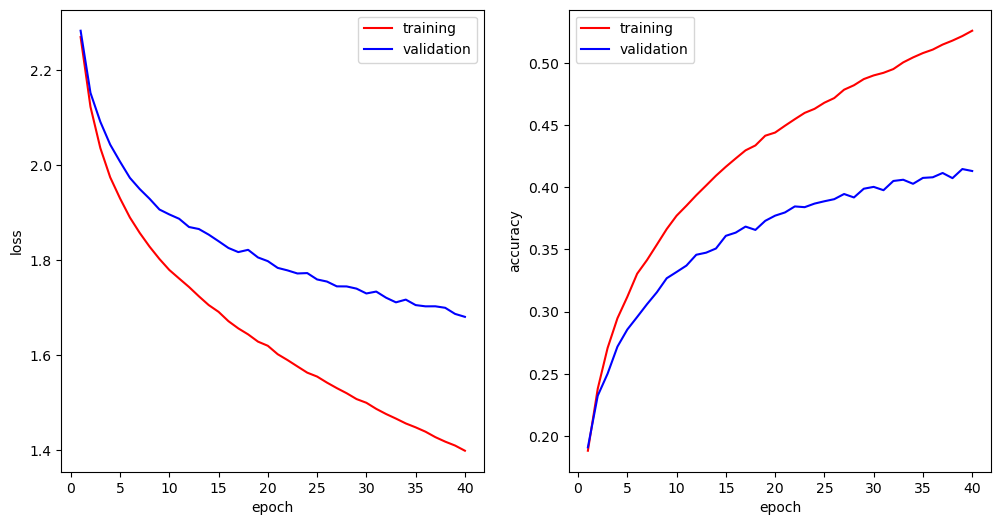

RESULTS
lr = 0.1000 : Accuracy = 0.5294896960258484
lr = 0.0100 : Accuracy = 0.6077730059623718
lr = 0.0010 : Accuracy = 0.48316851258277893
lr = 0.0001 : Accuracy = 0.41985759139060974

CPU times: user 4h 29min 25s, sys: 6.86 s, total: 4h 29min 32s
Wall time: 4h 28min 5s


In [10]:
%%time
n_splits = 5
rounds = 40
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adagrad

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()
